#  Analyse predictive des données structurées par l'intelligence artificielle 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:

df=pd.read_csv("join_transformed_last1.csv")


Nous commençons notre analyse par la visualisation des corrélations.

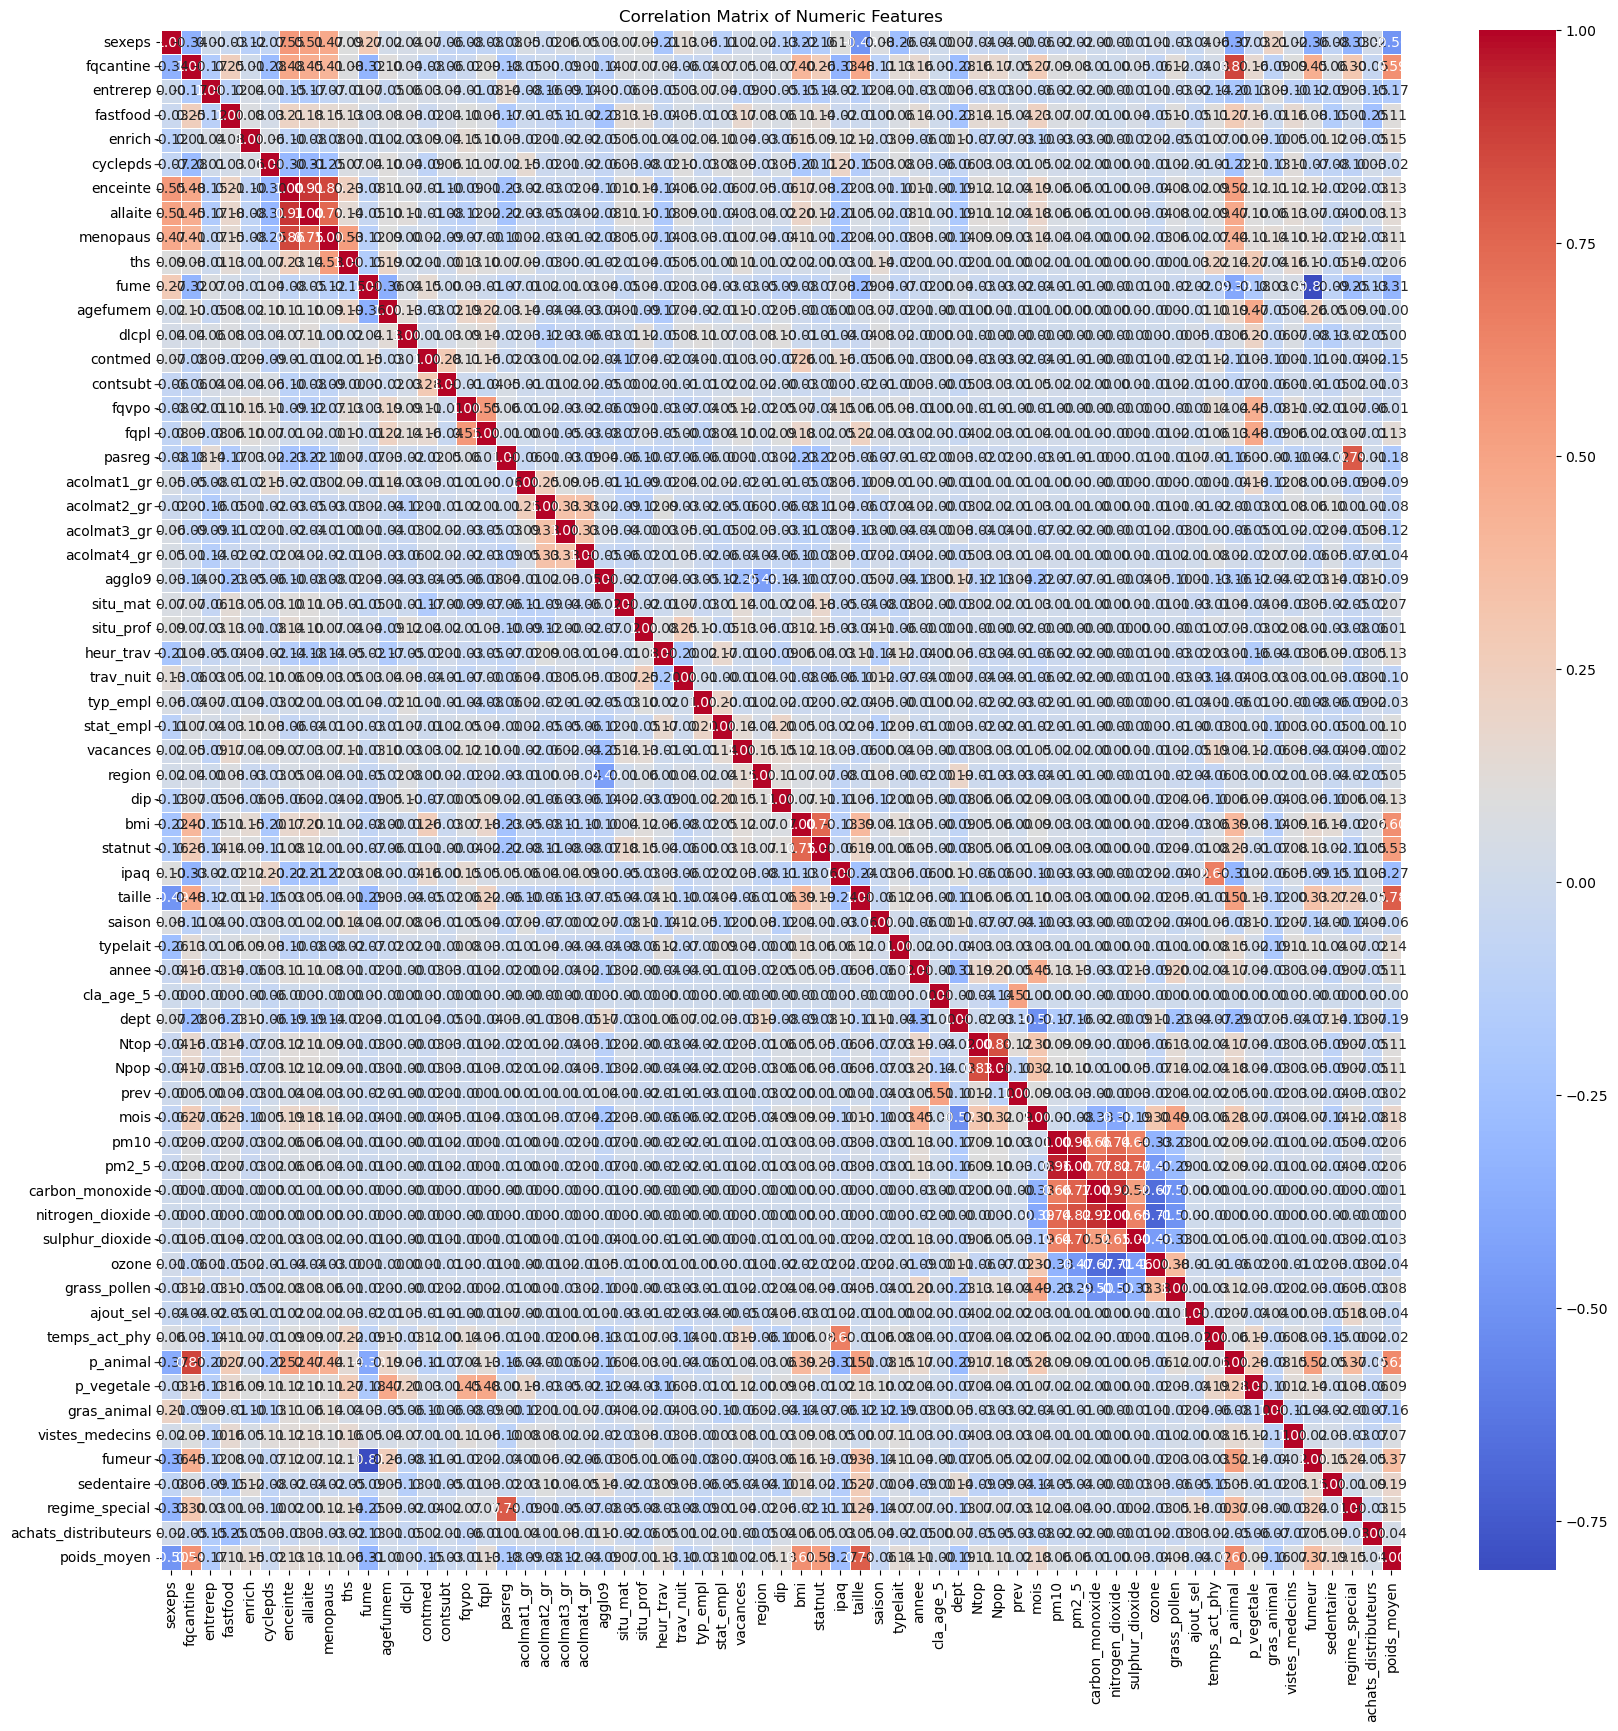

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrer le DataFrame pour ne prendre que les colonnes numériques
df_numeric = df.select_dtypes(include=['number'])

# Calculer la matrice de corrélation
corr_matrix = df_numeric.corr()

# Configurer la figure matplotlib
plt.figure(figsize=(20, 20))

# Dessiner la heatmap avec la matrice de corrélation
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)

# Ajouter des titres et des labels
plt.title('Correlation Matrix of Numeric Features')
plt.show()



Nous avons observé, grâce à cette matrice de corrélations, que certaines variables présentent des corrélations fortes (négatives ou positives). Cela nous aide à sélectionner les variables à utiliser pour réduire le nombre de caractéristiques dans la recherche du meilleur modèle. Voici les corrélations remarquées :

menopaus, allaite, enceinte et sexeps : plus de 80%
pasreg et regime_special : 70% et plus
statnul et poids_moyen : 50%
bmi, poids_moyen et taille : 60%
pm2_5 et pm10 : 90%
carbon_monoxyde et nitrogen_dioxide : 90%
ozone et sulphur_dioxide : 90%. 
Les corélations observées à 90% sont en lien avec les données de la qualité de l'ai mais ceci ne nous permet pas d'en exclure quelques une vus la saisonnalité de l'impact de certaines variables.
Nous avons également remarqué que notre variable cible est fortement corrélée à la classe d'âge (entre 0.9 et 1), ce qui nous amène à l'exclure du modèle. En effet, d'après le graphique réalisé lors des étapes de prétraitement, nous observons que toutes les tranches d'âge sont concernées par les maladies respiratoires chroniques.

# Réduction de la dimensionnalité des données

Dan la suite nous essayons de déterminer les features ayant le plus d'impact sur le modèle à réaliser.

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt



# Sélectionner les variables indépendantes (X) et la cible (y)
X = df.drop(columns=["Ntop", "patho_niv1", "cla_age_5", "Npop", "prev"]) #supprimer les variable qui influencent le modèle
y = df["Ntop"]  # colonne cible

# Séparation en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser et entraîner le modèle de régression LightGBM
model = LGBMRegressor()
model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer la performance du modèle
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R² Score

# Affichage des résultats de performance
print(f"RMSE : {rmse}")
print(f"R² : {r2}")



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.219089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1876
[LightGBM] [Info] Number of data points in the train set: 838860, number of used features: 59
[LightGBM] [Info] Start training from score -0.000225
RMSE : 0.4810564805217435
R² : 0.7694146964145666


# Etude des features les plus importantes pour le modèle


Top 10 des caractéristiques les plus importantes :
            Feature  Importance
5          cyclepds         652
30           region         518
39             dept         516
38            annee         337
40             mois         149
41             pm10          91
43  carbon_monoxide          47
58      poids_moyen          40
56   regime_special          38
50         p_animal          33

Top 10 des caractéristiques les plus importantes par permutation :
           Feature  Permutation Importance
30          region                2.689043
39            dept                2.474375
40            mois                1.741940
41            pm10                0.546123
5         cyclepds                0.007074
46           ozone                0.005382
38           annee                0.001970
58     poids_moyen                0.000073
18     acolmat1_gr                0.000049
56  regime_special                0.000038


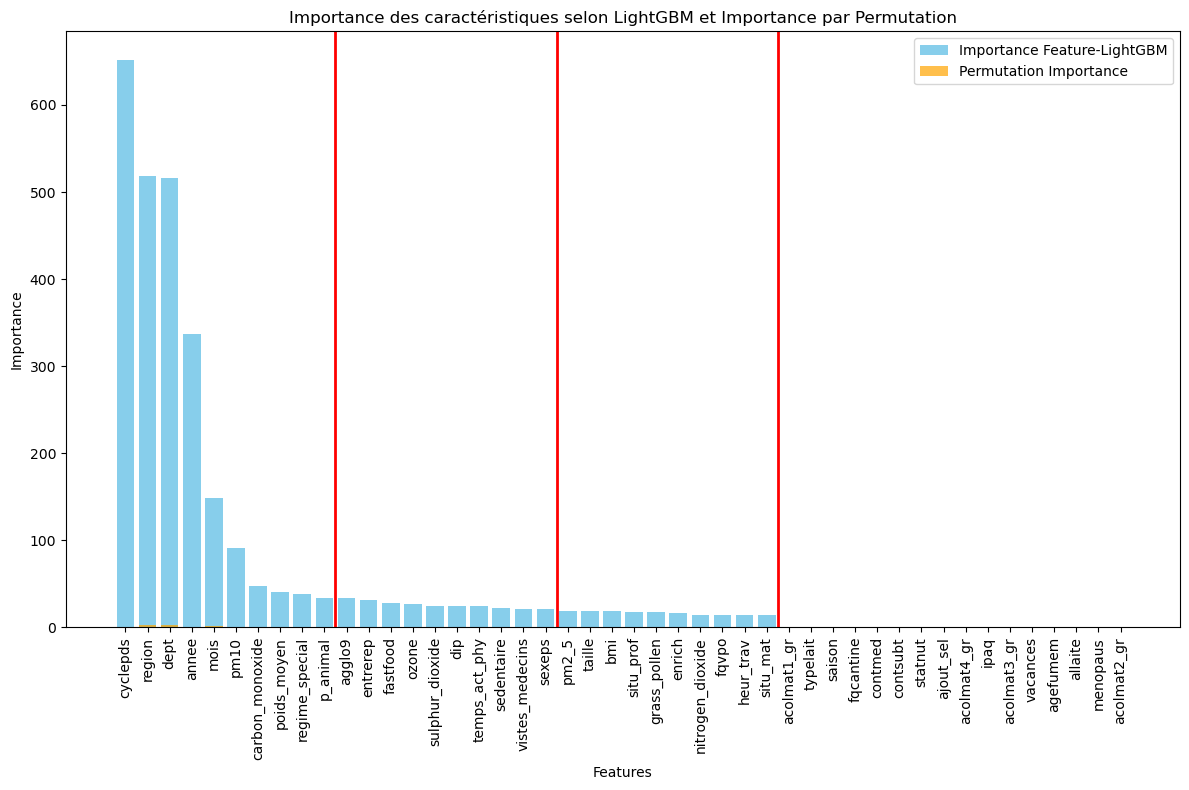

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import permutation_importance
#===================importance Features==========================
# Importance des caractéristiques par LightGBM
feature_importances = model.feature_importances_

# Créer un DataFrame pour une meilleure visualisation
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Trier les features par importance décroissante
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher les 10 caractéristiques les plus importantes
print("\nTop 10 des caractéristiques les plus importantes :")
print(importance_df.head(10))

#===========================Permutation Features=======================

# Calculer l'importance par permutation
perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42) # permutation 10 fois
#
# Créer un DataFrame pour l'importance par permutation
perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Permutation Importance': perm_importance.importances_mean
})

# Trier par importance décroissante
perm_importance_df = perm_importance_df.sort_values(by='Permutation Importance', ascending=False)

#=====================Affichage des Features===========================

# Afficher les 10 caractéristiques les plus importantes par permutation
print("\nTop 10 des caractéristiques les plus importantes par permutation :")
print(perm_importance_df.head(10))

# Limiter à 40 premières caractéristiques les plus importantes
importance_df = importance_df.head(30)
perm_importance_df = perm_importance_df.head(30)

#========================Affichage graphique des importances des caractéristiques
plt.figure(figsize=(12, 8))

# Barres verticales pour les importances sélectionnées par LightGBM
plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue', label='Importance Feature-LightGBM')

#========================Affichage graphique des permutation importance 

plt.bar(perm_importance_df['Feature'], perm_importance_df['Permutation Importance'], color='orange', alpha=0.7, label='Permutation Importance')



# Ajouter des lignes rouges de séparation après chaque 10 caractéristiques
for i in range(1, 4): 
    plt.axvline(x=i * 10 - 0.5, color='red', linewidth=2)

# Label des axes
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Importance des caractéristiques selon LightGBM et Importance par Permutation')

# Rotation des étiquettes de l'axe des X
plt.xticks(rotation=90)

# Ajuster l'affichage pour éviter que les éléments se chevauchent
plt.tight_layout()

# Ajouter la légende
plt.legend()

# Afficher le graphique
plt.show()


Après l'utilisation des deux méthodes de sélection des caractéristiques les plus importantes (l'importance des caractéristiques selon LightGBM et l'importance par permutation), nous avons observé que la méthode par permutation exclut plusieurs caractéristiques et n'en garde que quatre, ce qui ne nous convient pas. En effet, plusieurs caractéristiques qui sont apparues comme importantes dans la première méthode ont été exclues par la méthode de permutation. 

# Impact de l'utilisation des features importance avec LightGBM

In [16]:

# Extraire les 30 caractéristiques les plus importantes
# Liste des 30 caractéristiques les plus importantes
top_30_features = importance_df.head(30)['Feature'].tolist()

# Mettre à jour X pour ne contenir que ces 30 caractéristiques
X = df.drop(columns=["Ntop", "patho_niv1", "cla_age_5", "Npop", "prev"])  
X_top_30 = X[top_30_features]

# Vérifier la nouvelle forme de X_top_30
print(X_top_30.head())

# Séparer à nouveau les ensembles d'entraînement et de test avec les 30 caractéristiques sélectionnées
X_train, X_test, y_train, y_test = train_test_split(X_top_30, y, test_size=0.2, random_state=42)

# Réentraîner le modèle avec les 30 caractéristiques les plus importantes
model_top_30 = LGBMRegressor()
model_top_30.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = model_top_30.predict(X_test)

# Évaluation de la performance du modèle
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Affichage des résultats
print(f"RMSE avec les 30 caractéristiques les plus importantes : {rmse}")
print(f"R² avec les 30 caractéristiques les plus importantes : {r2}")



   cyclepds  region  dept  annee  mois      pm10  carbon_monoxide  \
0         1       0     8      1     0 -0.145786        -0.013922   
1         1       0    13      1     0 -0.145786        -0.013922   
2         1       0     8      1     0 -0.145786        -0.013922   
3         1       0    13      1     0 -0.145786        -0.013922   
4         1       0     8      1     0 -0.145786        -0.013922   

   poids_moyen  regime_special  p_animal  ...     pm2_5    taille       bmi  \
0     0.798936               6  0.438638  ... -0.142322  0.034288  1.439713   
1     0.798936               6  0.438638  ... -0.142322  0.034288  1.439713   
2     0.798936               6  0.438638  ... -0.142322  0.034288  1.439713   
3     0.798936               6  0.438638  ... -0.142322  0.034288  1.439713   
4     0.798936               6  0.438638  ... -0.142322  0.034288  1.439713   

   situ_prof  grass_pollen  enrich  nitrogen_dioxide  fqvpo  heur_trav  \
0          0     -0.201667       1  

Nous remarquons ici que la sélection des features les plus importantes n'a pas impacté les résultats obtenus avec LightGBM.
Dans la suite des traitements et des tests de machine learning nous allons continuer à travailler avec les 30 features sélectionnées précedemment.

# Recherche du meilleur modèle sur la totalité des données du DataFrame avec 30 features

## Fonction d'évaluation du meilleur modèle

In [38]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd  

# Initialisation du DataFrame des résultats si nécessaire
results_df = pd.DataFrame(columns=["Model", "Best_Params", "R²", "MSE", "RMSE"])

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, best_params):
    # Entraînement du modèle
    model.fit(X_train, y_train)
    
    # Prédictions sur l'ensemble de test
    y_pred = model.predict(X_test)
    
    # Calcul des métriques de performance
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Affichage des résultats
    print(f"Le meilleur R² pour {model_name} est : {r2:.4f}")
    print(f"Le meilleur MSE pour {model_name} est : {mse:.4f}")
    print(f"Le meilleur RMSE pour {model_name} est : {rmse:.4f}")
    
    # Ajouter les résultats au DataFrame
    global results_df  # Pour s'assurer que nous modifions la variable globale
    results_df.loc[len(results_df)] = [model_name, str(best_params), r2, mse, rmse]
    
    # Retourner les résultats
    return r2, mse, rmse

Dans cette étude, plusieurs modèles ont été testés pour optimiser les prédictions du nombre de patients "Ntop", en fonction des caractéristiques les plus importantes qui ont été sélectionnées précédemment. Cependant, les temps d'exécution très lents et les dépassements de capacités des machines ont rendu l'utilisation de l'ensemble des données impraticable, nous contraignant à abandonner cette approche.
Seuls les modèles Ridge, Lasso, DecisionTreeRegressor, LGBMRegressor et GradientBoostingRegressor ont permis d'obtenir des résultats dans des délais d'exécution raisonnables.

In [70]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Définition des données d'entrée
X = df[top_30_features]  
y = df["Ntop"]  # Variable cible

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Affichage de la forme des données pour vérifier que la division a bien fonctionné
print(f"Shape of X_train: {X_train.shape}") 
print(f"Shape of X_test: {X_test.shape}")   
print(f"Shape of y_train: {y_train.shape}")  
print(f"Shape of y_test: {y_test.shape}")    

Shape of X_train: (838860, 30)
Shape of X_test: (209715, 30)
Shape of y_train: (838860,)
Shape of y_test: (209715,)


In [23]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import gc

# Définir la grille de recherche
param_grid_lasso = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

# Initialisation du modèle Lasso
lasso = Lasso()

# Définir GridSearchCV pour rechercher les meilleurs hyperparamètres
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, cv=5, scoring='neg_mean_squared_error')

# Appliquer GridSearchCV
grid_search_lasso.fit(X_train, y_train)

# Obtenir le meilleur modèle et les meilleurs paramètres
best_lasso_model = grid_search_lasso.best_estimator_
best_lasso_params = grid_search_lasso.best_params_

# Faire des prédictions avec le meilleur modèle Lasso
y_pred_lasso = best_lasso_model.predict(X_test)

# Appel de la fonction d'évaluation pour Lasso
r2_lasso, mse_lasso, rmse_lasso = evaluate_model(best_lasso_model, X_train, X_test, y_train, y_test, "Lasso", best_lasso_params)


# Libérer la mémoire
gc.collect()

Le meilleur R² pour Lasso est : 0.2062
Le meilleur MSE pour Lasso est : 0.7967
Le meilleur RMSE pour Lasso est : 0.8926


237888

In [24]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import gc
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Définir le modèle Ridge
ridge = Ridge()

# Définir la grille de paramètres pour Ridge
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0]} 

# Définir GridSearchCV
grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid_ridge, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Appliquer GridSearchCV
grid_search_ridge.fit(X_train, y_train)

# Obtenir le meilleur modèle et les meilleurs paramètres
best_ridge_model = grid_search_ridge.best_estimator_
best_ridge_params = grid_search_ridge.best_params_

# Affichage des meilleurs paramètres trouvés
print(f"Meilleurs paramètres pour Ridge : {best_ridge_params}")

# Prédiction sur les données de test
y_pred_ridge = best_ridge_model.predict(X_test)

# Appel de la fonction d'évaluation pour Ridge
r2_ridge, mse_ridge, rmse_ridge = evaluate_model(best_ridge_model, X_train, X_test, y_train, y_test, "Ridge", best_ridge_params)


# Libérer la mémoire
gc.collect()


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Meilleurs paramètres pour Ridge : {'alpha': 10.0}
Le meilleur R² pour Ridge est : 0.2091
Le meilleur MSE pour Ridge est : 0.7938
Le meilleur RMSE pour Ridge est : 0.8909


26

In [25]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import gc
import matplotlib.pyplot as plt


# Définir le modèle LightGBM
lgbm = LGBMRegressor()

# Définir la grille de paramètres pour LightGBM
param_grid_lgbm = {
    'n_estimators': [100], 
    'learning_rate': [0.1], 
    'num_leaves': [31],
}

# Définir GridSearchCV
grid_search_lgbm = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid_lgbm,
    cv=3,  # Nombre de plis pour la validation croisée
    scoring='r2',  # maximiser r2 score
    n_jobs=-1,  # Utilisation de tous les cœurs CPU disponibles
    verbose=2  # Affichage détaillé de la progression
)


# Appliquer GridSearchCV
grid_search_lgbm.fit(X_train, y_train)

# Obtenir le meilleur modèle et les meilleurs paramètres
best_model_lgbm = grid_search_lgbm.best_estimator_
best_lgbm_params = grid_search_lgbm.best_params_

# Faire des prédictions sur les données de test
y_pred = best_model_lgbm.predict(X_test)

#Evaluation du modèle
r2_lgbm, mse_lgbm, rmse_lgbm = evaluate_model(best_model_lgbm, X_train, X_test, y_train, y_test, "Lgbm", best_lgbm_params)

# Libérer la mémoire
gc.collect()



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1570
[LightGBM] [Info] Number of data points in the train set: 838860, number of used features: 30
[LightGBM] [Info] Start training from score -0.000225
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1570
[LightGBM] [Info] Number of data points in the train set: 838860, number of used features: 30
[LightGBM] [Info] Start training from score -0.000225
Le meilleur R² pour Lgbm est : 0.7699
Le meilleur MSE pour Lgbm est : 0.2309
Le meilleur RMSE pour Lgbm est : 0.4805


80

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import gc

# Définir le modèle Decision Tree
dt = DecisionTreeRegressor()

# Définir la grille de paramètres pour Decision Tree
param_grid_dt = {
    'max_depth': [20],
    'min_samples_split': [2],
    'min_samples_leaf': [2]
}

# Définir GridSearchCV
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=3, scoring='r2', n_jobs=-1, verbose=2)

# Appliquer GridSearchCV
grid_search_dt.fit(X_train, y_train)

# Obtenir le meilleur modèle et les meilleurs paramètres
best_dt_model = grid_search_dt.best_estimator_
best_dt_params = grid_search_dt.best_params_

# Utiliser la fonction evaluate_model pour l'évaluation (assurez-vous que cette fonction est définie)
r2_dt, mse_dt, rmse_dt=evaluate_model(best_dt_model, X_train, X_test, y_train, y_test, 'Decision Tree', best_dt_params)


# Faire des prédictions sur les données de test
y_pred = best_dt_model.predict(X_test)
 
# Libérer la mémoire
gc.collect()


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Le meilleur R² pour Decision Tree est : 0.7588
Le meilleur MSE pour Decision Tree est : 0.2420
Le meilleur RMSE pour Decision Tree est : 0.4920


26

In [37]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

# Définir le modèle Random Forest
rf = RandomForestRegressor()

# Définir la grille de paramètres pour Random Forest 
param_grid_rf = {
    'n_estimators': [100],
}

# Paramètres pour GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid_rf, 
    cv=3,  # k-folds=3 découpe
    scoring='r2',  
    verbose=2,  
    n_jobs=-1  
)

# Appliquer GridSearchCV sur les données d'entraînement
grid_search_rf.fit(X_train, y_train)

# Obtenir les meilleurs paramètres de RandomForestRegressor
best_rf_model = grid_search_rf.best_estimator_
best_rf_params = grid_search_rf.best_params_


# Utiliser la fonction evaluate_model pour l'évaluation (assurez-vous que cette fonction est définie)
r2_rf, mse_rf, rmse_rf = evaluate_model(best_rf_model, X_train, X_test, y_train, y_test, 'Random Forest', best_rf_params)


# Faire des prédictions sur les données de test
y_pred = best_dt_model.predict(X_test)
 
# Libérer la mémoire
gc.collect()

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Le meilleur R² pour Random Forest est : 0.7578
Le meilleur MSE pour Random Forest est : 0.2430
Le meilleur RMSE pour Random Forest est : 0.4930


0

In [38]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
import gc

# Définir le modèle Gradient Boosting
gb = GradientBoostingRegressor()

# Définir la grille de paramètres pour Gradient Boosting
param_grid_gb = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [3]
}

# Définir GridSearchCV
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=3, scoring='r2', n_jobs=-1, verbose=2)

# Appliquer GridSearchCV sur les données échantillonnées
grid_search_gb.fit(X, y)

# Obtenir le meilleur modèle et les meilleurs paramètres
best_gb_model = grid_search_gb.best_estimator_
best_gb_params = grid_search_gb.best_params_

#calcul des prédictions
y_pred= best_gb_model.predict(X_test)

# Évaluation du modèle avec la fonction d'évaluation 
r2_gb, mse_gb, rmse_gb =evaluate_model(best_gb_model, X_train, X_test, y_train, y_test, 'Gradient Boosting', best_gb_params)

# Libérer la mémoire
gc.collect()


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Le meilleur R² pour Gradient Boosting est : 0.7362
Le meilleur MSE pour Gradient Boosting est : 0.2647
Le meilleur RMSE pour Gradient Boosting est : 0.5145


26

In [41]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import gc

# Définir le modèle XGBoost pour la régression
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# Définir la grille de paramètres pour XGBoost
param_grid_xgb = {
    'n_estimators': [100], 
    'max_depth': [10],        
    'learning_rate': [0.1],     
 
}


# Définir GridSearchCV avec k-fold validation
grid_search_xgb = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid_xgb, 
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # Critère de performance
    n_jobs=-1,  # Utilisation de tous les cœurs CPU disponibles
    verbose=2   # Affichage détaillé 
)

# Appliquer GridSearchCV sur les données d'entraînement
grid_search_xgb.fit(X_train, y_train)

# Obtenir le meilleur modèle et les meilleurs paramètres
best_xgb_model = grid_search_xgb.best_estimator_
best_xgb_params = grid_search_xgb.best_params_

#calcul des prédictions 
y_pred= best_xgb_model.predict(X_test)



# Appel de la fonction d'évaluation
r2_xgb, mes_xgb, rmse_xgb= evaluate_model(best_xgb_model, X_train, X_test, y_train, y_test, 'XGBoost', best_xgb_params)
# Libérer la mémoire
gc.collect()


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Le meilleur R² pour XGBoost est : 0.7619
Le meilleur MSE pour XGBoost est : 0.2389
Le meilleur RMSE pour XGBoost est : 0.4888


47

In [45]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import gc


# Définir le modèle KNeighbors 
knn_model = KNeighborsRegressor()

# Définir la grille de paramètres pour KNeighbors
param_grid_knn = {
    'n_neighbors': [5],          # Nombre de voisins
    'weights': ['uniform'],     # Poids des voisins
    'algorithm': ['auto'],  # Méthode d'algorithme
    'p': [2]                            
}

# Définir GridSearchCV avec k-fold validation
grid_search_knn = GridSearchCV(
    estimator=knn_model, 
    param_grid=param_grid_knn, 
    cv=5,  # 5-fold cross-validation
    scoring='r2',  
    n_jobs=-1
)


# Appliquer GridSearchCV sur les données d'entraînement
grid_search_knn.fit(X_train, y_train)

# Obtenir le meilleur modèle et les meilleurs paramètres
best_knn_model = grid_search_knn.best_estimator_
best_knn_params = grid_search_knn.best_params_


# Appel de la fonction d'évaluation 
re_knn, mse_knn, rmse_knn = evaluate_model(best_knn_model, X_train, X_test, y_train, y_test, 'KNeighbors', best_knn_params)

# Libérer la mémoire
gc.collect()


Le meilleur R² pour KNeighbors est : 0.7182
Le meilleur MSE pour KNeighbors est : 0.2828
Le meilleur RMSE pour KNeighbors est : 0.5318


26

In [46]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import gc
# Définir le modèle ElasticNet pour la régression
elasticnet_model = ElasticNet()

# Définir la grille de paramètres pour ElasticNet
param_grid_elasticnet = {
    'alpha': [0.1],        # Paramètre de régularisation L1 et L2
    'l1_ratio': [0.5],      # Ratio de régularisation L1 par rapport à L2
}

# Définir GridSearchCV avec k-fold validation
grid_search_elasticnet = GridSearchCV(
    estimator=elasticnet_model, 
    param_grid=param_grid_elasticnet, 
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # Critère de performance : MSE négatif pour minimiser
    n_jobs=-1,  # Utilisation de tous les cœurs CPU disponibles
    verbose=2   # Affichage détaillé de la progression de la recherche par grille
)

# Appliquer GridSearchCV sur les données d'entraînement
grid_search_elasticnet.fit(X_train, y_train)

# Obtenir le meilleur modèle et les meilleurs paramètres
best_elasticnet_model = grid_search_elasticnet.best_estimator_
best_elasticnet_params = grid_search_elasticnet.best_params_


#calcul des predictions 
y_test_pred = best_elasticnet_model.predict(X_test)

# Appel de la fonction d'évaluation 
r2_en, mse_en, rmse_en = evaluate_model(best_elasticnet_model, X_train, X_test, y_train, y_test, 'ElasticNet', best_elasticnet_params)
# Libérer la mémoire
gc.collect()


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Le meilleur R² pour ElasticNet est : 0.1838
Le meilleur MSE pour ElasticNet est : 0.8191
Le meilleur RMSE pour ElasticNet est : 0.9051


26

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import gc

# Définir le modèle SVR
svr = SVR()

# Définir la grille de paramètres pour SVR
param_grid_svr = {
    'C': [1.0],
    'epsilon': [0.1],
    'kernel': ['linear']
}

# Définir GridSearchCV
grid_search_svr = GridSearchCV(estimator=svr, param_grid=param_grid_svr, cv=3, scoring='r2', n_jobs=-1, verbose=2)

# Appliquer GridSearchCV
grid_search_svr.fit(X_train, y_train)

# Obtenir le meilleur modèle et les meilleurs paramètres
best_svr_model = grid_search_svr.best_estimator_
best_svr_params = grid_search_svr.best_params_

#calcul des predictions 
y_pred= best_svr_model.predict(X_test)

# Évaluation du modèle
re_svr, mse_svr, rmse_svr= evaluate_model(best_svr_model, X_train, X_test, y_train, y_test, 'SVR', best_svr_params)

# Libérer la mémoire
gc.collect()


Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
# Appel de la fonction evaluate_model pour chaque modèle
for model_name, model in models.items():
    r2 = evaluate_model(model, X_train, X_test, y_train, y_test, model_name, param_grids.get(model_name))
    
    # Prédire les valeurs sur les données de test en dehors de la fonction
    y_pred = model.predict(X_test)
    
    # Affichage des résultats avec nuage de points et droite idéale
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', label='Valeurs prédites', alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Droite idéale')
    plt.legend()
    plt.title(f'{model_name} - Valeurs réelles vs prédits')
    plt.xlabel('Valeurs réelles')
    plt.ylabel('Valeurs prédites')
    plt.show()

Après plusieurs tentatives d'entraînement des modèles de Machine Learning sur l'ensemble du dataset, nous avons rencontré des difficultés pour obtenir des résultats fiables en raison de la taille importante des données. Pour pallier ce problème, nous avons appliqué l'algorithme K-means pour effectuer un clustering du dataset initial. Cette méthode nous a permis de diviser les données en sous-groupes plus petits et représentatifs, rendant ainsi les tests plus faciles à réaliser sur un échantillon plus manageable.

# Préparation des Données pour l'Évaluation des Modèles de Machine Learning avec clustering

Les étapes ci dessous décrivent le processus de clusterisation afin de pouvoir réaliser les tests de machine learning sur des données moins volumineuses. Nous continuons à travailler avec les features réduites à 30.

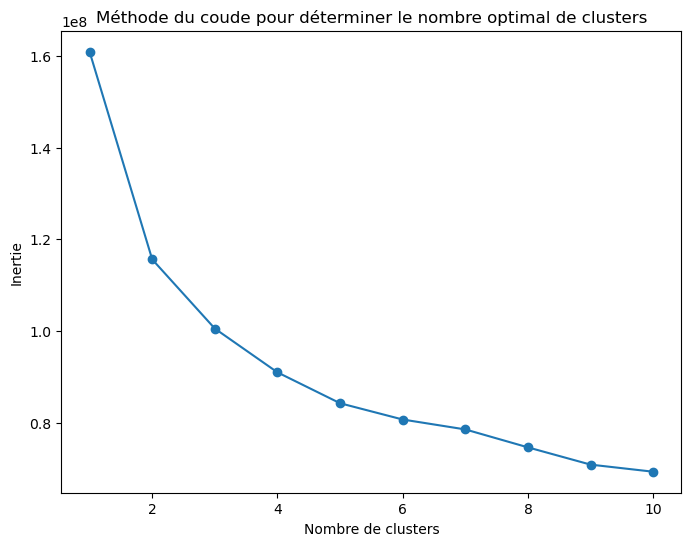

Le nombre optimal de clusters selon la méthode du coude est 2


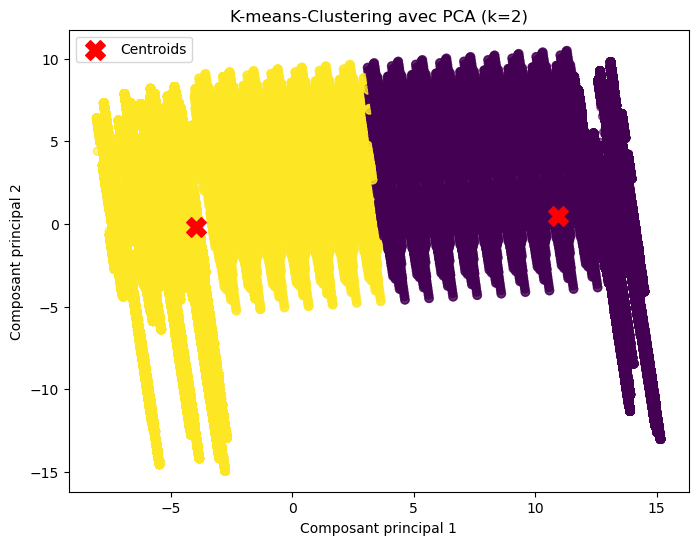

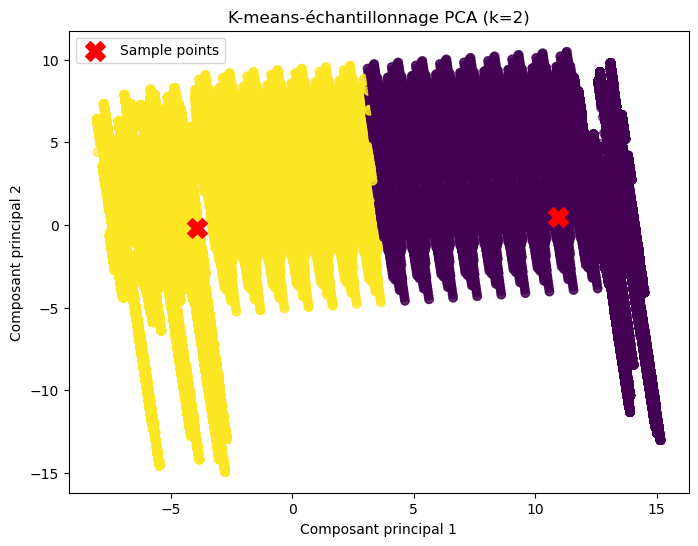

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Définition des données 
X = df[top_30_features]  
y = df["Ntop"]  # Variable cible


# Appliquer PCA sur les données déjà scalées
pca = PCA(n_components=2)  # Réduction à 2 dimensions pour la visualisation
X_pca = pca.fit_transform(X)

# Recherche du meilleur nombre de clusters avec la méthode du coude
inerties = []
max_k = 10  # jusqu'à 10 clusters
for k in range(1, max_k + 1):  
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inerties.append(kmeans.inertia_)

# Tracer l'inertie en fonction du nombre de clusters
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_k + 1), inerties, marker='o')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.show()

# ici j'ai ajusté le nombre de clusters à 2 après la visualisation de la courbe d'inertie
optimal_k = 2  
print(f"Le nombre optimal de clusters selon la méthode du coude est {optimal_k}")

# j'aplique le K-means sur les données réduites avec PCA et le nombre optimal de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(X_pca)

# clusters pour chaque point de données
labels = kmeans.labels_

# Centroides des clusters
centroids = kmeans.cluster_centers_

# Visualisation des clusters dans l'espace réduit
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, color='red', label='Centroids')
plt.title(f'K-means-Clustering avec PCA (k={optimal_k})')
plt.xlabel('Composant principal 1')
plt.ylabel('Composant principal 2')
plt.legend()
plt.show()

# Sélectionner un échantillon en fonction de la distance des centroîdes
for i in range(kmeans.n_clusters):
    cluster_points = X_pca[labels == i]
    centroid = centroids[i]
    closest_point_idx = np.argmin(np.linalg.norm(cluster_points - centroid, axis=1))
    sample_points.append(cluster_points[closest_point_idx])

sample_points = np.array(sample_points)


Cette représentation graphique illustre la formation de deux clusters autour de leurs centroïdes respectifs, où chaque cluster regroupe
les points les plus proches du centre, déterminé par un calcul vectoriel de distance. 
Ces centroïdes sont les points centraux de chaque groupe, calculés pour minimiser la distance totale entre les points du cluster 
et le centroïde.

# Sélection du cluster qui fera l'objet des tests de ML

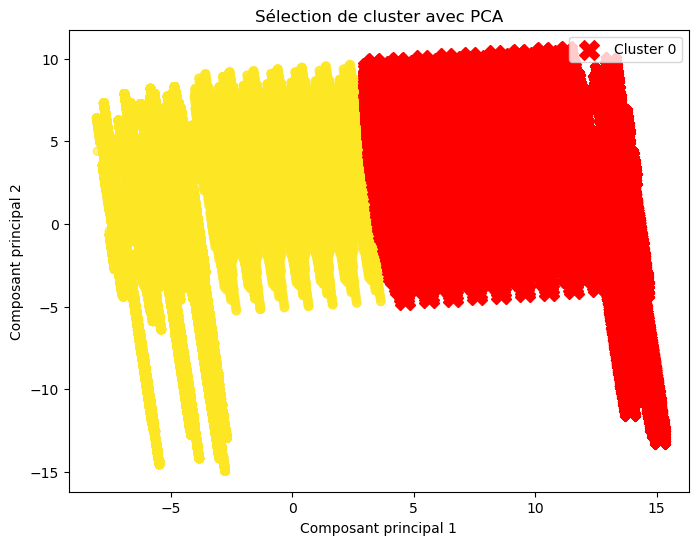

In [90]:
# Sélectionner les points du cluster 0
cluster_index = 0 
selected_cluster_points = X_pca[labels == cluster_index]

# Visualiser les points du cluster sélectionné
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(selected_cluster_points[:, 0], selected_cluster_points[:, 1], marker='X', s=200, color='blue', label=f'Cluster {cluster_index}')
plt.title(f'Sélection de cluster avec PCA')
plt.xlabel('Composant principal 1')
plt.ylabel('Composant principal 2')
plt.legend()
plt.show()


Le cluster coloré en rouge sera utilisé pour les tests de Machine Learning.

# Evaluation des Modèles ML avec le cluster sélectionné

In [94]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd


# Filtrer les points appartenant au cluster 0
cluster_0_points = X[labels == 0]  # Sélectionner toutes les lignes correspondant au cluster 0
y_cluster_0 = y[labels == 0]  # Sélectionner la valeur cible

# Réinitialiser les indices de X et y pour éviter un désalignement
cluster_0_points = cluster_0_points.reset_index(drop=True)
y_cluster_0 = y_cluster_0.reset_index(drop=True)

# Vérification de la taille des DataFrames filtrés
print(f"Dimensions de X (cluster 0): {cluster_0_points.shape}")
print(f"Dimensions de y (cluster 0): {y_cluster_0.shape}")

# Séparer les caractéristiques X et la cible y

X_cluster_0 = cluster_0_points
X_cluster_0.columns = X_cluster_0.columns.str.strip()  
y_cluster_0 = y_cluster_0  # La cible est déjà définie

# Séparer les données en jeu d'entraînement et jeu de test (80% - 20% par exemple)
X_train, X_test, y_train, y_test = train_test_split(X_cluster_0, y_cluster_0, test_size=0.2, random_state=42)

# Initialiser le modèle LightGBM
model = LGBMRegressor()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Prédire les valeurs sur le jeu de test
y_pred = model.predict(X_test)

# Évaluer les performances du modèle
mse = mean_squared_error(y_test, y_pred)  
rmse = np.sqrt(mse)  
r2 = r2_score(y_test, y_pred)  

# Afficher les résultats
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


Dimensions de X (cluster 0): (277734, 30)
Dimensions de y (cluster 0): (277734,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1320
[LightGBM] [Info] Number of data points in the train set: 222187, number of used features: 30
[LightGBM] [Info] Start training from score 0.051873
RMSE: 0.524385009071254
R²: 0.7699217436890033


# Recherche du meilleur modèle avec les 30 features les plus importantes

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor 
import xgboost as xgb
import joblib


# Initialiser le DataFrame pour les résultats
results_df = pd.DataFrame(columns=['Model', 'Best Params', 'R2 Score', 'MSE', 'RMSE'])

# Définir les modèles à tester et les paramètres pour RandomizedSearchCV
models = {
    'Lasso Regression': Lasso(),
    'Ridge Regression': Ridge(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'ElasticNet': ElasticNet(),
    'LightGBM': LGBMRegressor(),
    'XGBoost': xgb.XGBRegressor(),
    'KNeighbors': KNeighborsRegressor()
}

param_grids = {
    'Lasso Regression': {'alpha': np.logspace(-4, 1, 10)},  
    'Ridge Regression': {'alpha': np.logspace(-4, 1, 10)}, 
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},  
    'Gradient Boosting': {'n_estimators': [100], 'learning_rate': [0.05], 'max_depth': [3, 5]}, 
    'SVR': {'C': [1.0], 'epsilon': [0.1]},  # Valeurs typiques utilisées dans SVR
    'Decision Tree': {'max_depth': [5, 10]}, 
    'ElasticNet': {'alpha': [0.1], 'l1_ratio': [0.5]},  # Valeurs typiques pour ElasticNet
    'LightGBM': {'n_estimators': [100], 'learning_rate': [0.05]},  
    'XGBoost': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [5, 10, 15]},  
    'KNeighbors': {'n_neighbors': [5, 10, 15]}
}

# Définir le K-Fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Définir le scorer pour RandomizedSearchCV
scorer = make_scorer(r2_score)

# Variables pour stocker les résultats des prédictions pour chaque modèle
all_y_test_vals = []
all_y_pred_vals = []
all_model_names = []

# Initialisation des meilleures performances
best_r2 = -np.inf # valeur négative
best_model = None
best_model_name = ""
best_params = {}

# Boucle d'entraînement et d'évaluation des modèles
for model_name, model in models.items():
    try:
        # Effectuer la recherche aléatoire des hyperparamètres pour chaque modèle
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grids[model_name],
            n_iter=4,  # le nombre d'itérations ajusté au fil des exécutions
            cv=kf,
            n_jobs=-1,
            verbose=2,
            random_state=42,
            scoring='r2'  # Utilisation du R² comme critère de score
        )
        
        random_search.fit(X_train, y_train)
        best_model_candidate = random_search.best_estimator_
        best_params_candidate = random_search.best_params_

        # Prédictions avec le meilleur modèle trouvé
        y_pred = best_model_candidate.predict(X_test)

        # Sauvegarder les valeurs de y_test et y_pred pour le plot
        all_y_test_vals.append(y_test)  # y_test est la valeur réelle
        all_y_pred_vals.append(y_pred)  # y_pred est la prédiction du modèle
        all_model_names.append(model_name)

        # Évaluer le modèle et obtenir ses métriques
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        # Sauvegarder les résultats dans le DataFrame
        results_df.loc[len(results_df)] = [model_name, str(best_params_candidate), r2, mse, rmse]

        # Si ce modèle a un meilleur R², le sauvegarder comme meilleur modèle
        if r2 > best_r2:
            best_r2 = r2
            best_model = best_model_candidate
            best_model_name = model_name
            best_params = best_params_candidate

    except Exception as e:
        print(f"Erreur lors de l'ajustement du modèle {model_name} : {e}")
        continue  # Passer au modèle suivant

# Sauvegarder le meilleur modèle basé sur le R²
if best_model:
    joblib_file = f"{best_model_name.replace(' ', '_')}_best_model.pkl"
    joblib.dump(best_model, joblib_file)
   # Sauvegarder le modèle et le scaler
    joblib.dump(scaler, "models/scaler.pkl")
    print(" Modèle et scaler sauvegardés !")
    
    print(f"Le meilleur modèle ({best_model_name}) avec R² de {best_r2} a été sauvegardé dans le fichier : {joblib_file}")
else:
    print("Aucun modèle n'a été trouvé pour être sauvegardé.")

# Afficher les résultats triés par R²
results_df_sorted = results_df.sort_values(by='R2 Score', ascending=False)
print(results_df_sorted)

# Sauvegarder les résultats triés dans un fichier CSV
results_df_sorted.to_csv("results_ML_random_sorted_by_R4.csv", index=False)





Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\fatma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=4. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\fatma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=4. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\fatma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=4. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\fatma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=4. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\fatma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=4. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1320
[LightGBM] [Info] Number of data points in the train set: 222187, number of used features: 30
[LightGBM] [Info] Start training from score 0.051873
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\fatma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=4. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits
 Modèle et scaler sauvegardés !
Le meilleur modèle (LightGBM) avec R² de 0.7717577815847319 a été sauvegardé dans le fichier : LightGBM_best_model.pkl
               Model                                        Best Params  \
7           LightGBM       {'n_estimators': 100, 'learning_rate': 0.05}   
8            XGBoost  {'n_estimators': 100, 'max_depth': 5, 'learnin...   
3  Gradient Boosting  {'n_estimators': 100, 'max_depth': 5, 'learnin...   
2      Random Forest             {'n_estimators': 200, 'max_depth': 10}   
5      Decision Tree                                  {'max_depth': 10}   
9         KNeighbors                                {'n_neighbors': 15}   
4                SVR                         {'epsilon': 0.1, 'C': 1.0}   
1   Ridge Regression                       {'alpha': 2.782559402207126}   
0   Lasso Regression                  {'alpha': 0.00035938136638046257}   
6         ElasticNet                    

Les résultats obtenus à partir de l'échantillon de données permettent de bien refléter l'ensemble des données, car les mesures suivent le même ordre que celles de l'ensemble complet.

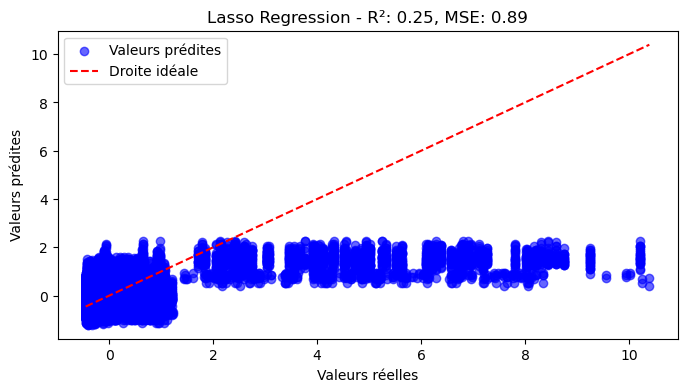

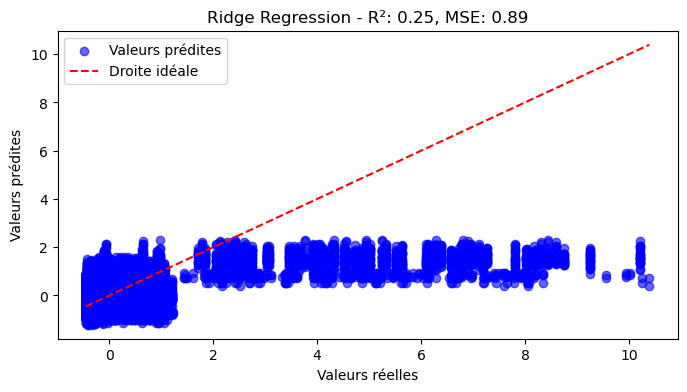

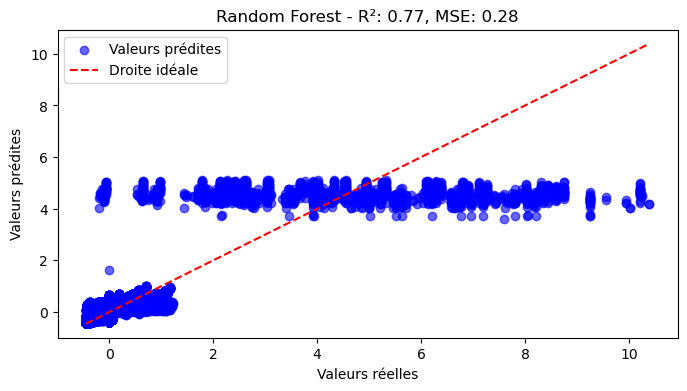

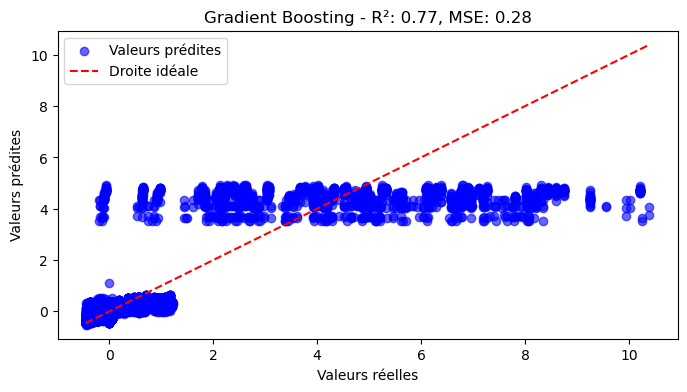

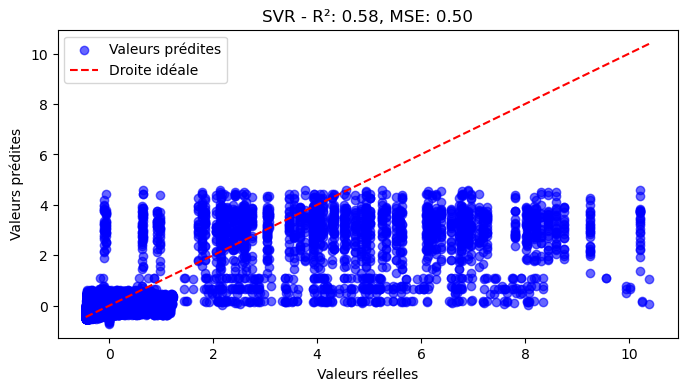

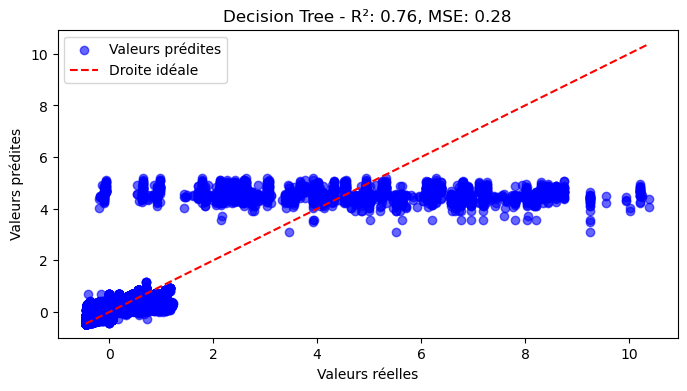

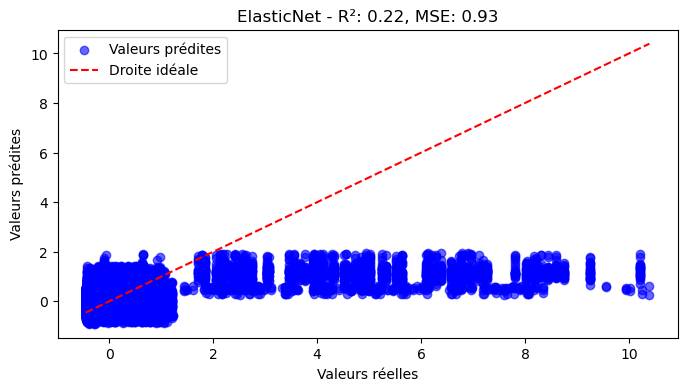

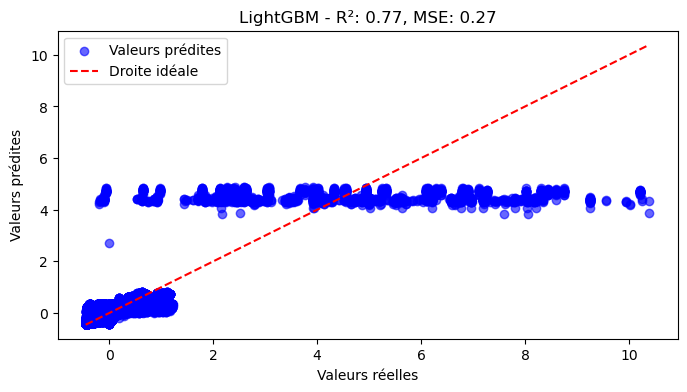

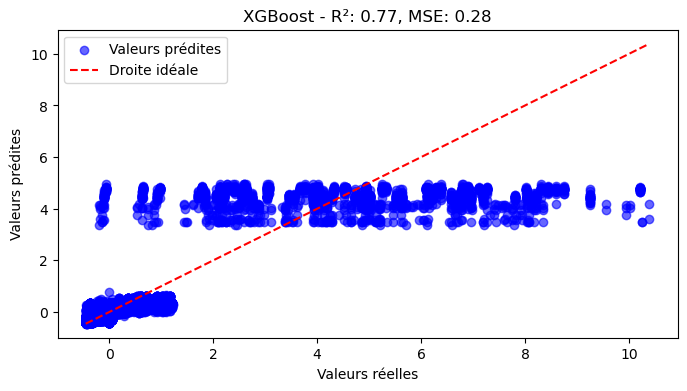

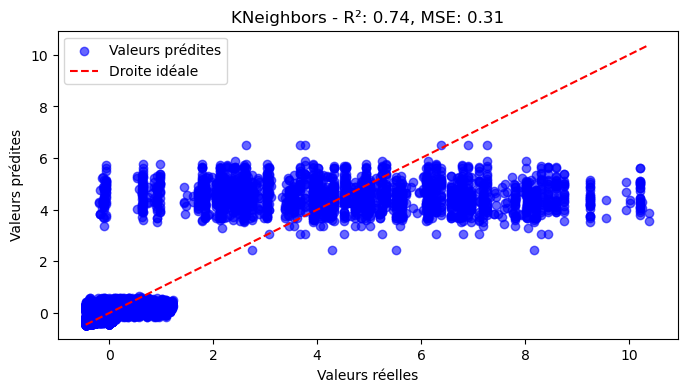

In [98]:
# Fonction pour afficher les résultats un par un
def plot_all_results_individually(all_y_test_vals, all_y_pred_vals, all_model_names):
    num_models = len(all_model_names)
    
    for i in range(num_models):
        try:
            # Récupérer les valeurs de y_test et y_pred pour le modèle courant
            y_test_vals = all_y_test_vals[i]
            y_pred_vals = all_y_pred_vals[i]
            model_name = all_model_names[i]
            
            # Calculer le R² et MSE pour afficher sur le graphique
            r2 = r2_score(y_test_vals, y_pred_vals)
            mse = mean_squared_error(y_test_vals, y_pred_vals)
            
            # Affichage des résultats avec nuage de points et droite idéale
            plt.figure(figsize=(8, 4))
            plt.scatter(y_test_vals, y_pred_vals, color='blue', label='Valeurs prédites', alpha=0.6)
            plt.plot([min(y_test_vals), max(y_test_vals)], [min(y_test_vals), max(y_test_vals)], color='red', linestyle='--', label='Droite idéale')
            
            # Ajouter des légendes et titres
            plt.legend()
            plt.title(f'{model_name} - R²: {r2:.2f}, MSE: {mse:.2f}')
            plt.xlabel('Valeurs réelles')
            plt.ylabel('Valeurs prédites')
            plt.show()
      
        except Exception as e:
            print(f"Erreur lors de l'évaluation du modèle {model_name}: {e}")
            continue  # Passer au modèle suivant

# Afficher les graphiques un par un
plot_all_results_individually(all_y_test_vals, all_y_pred_vals, all_model_names)

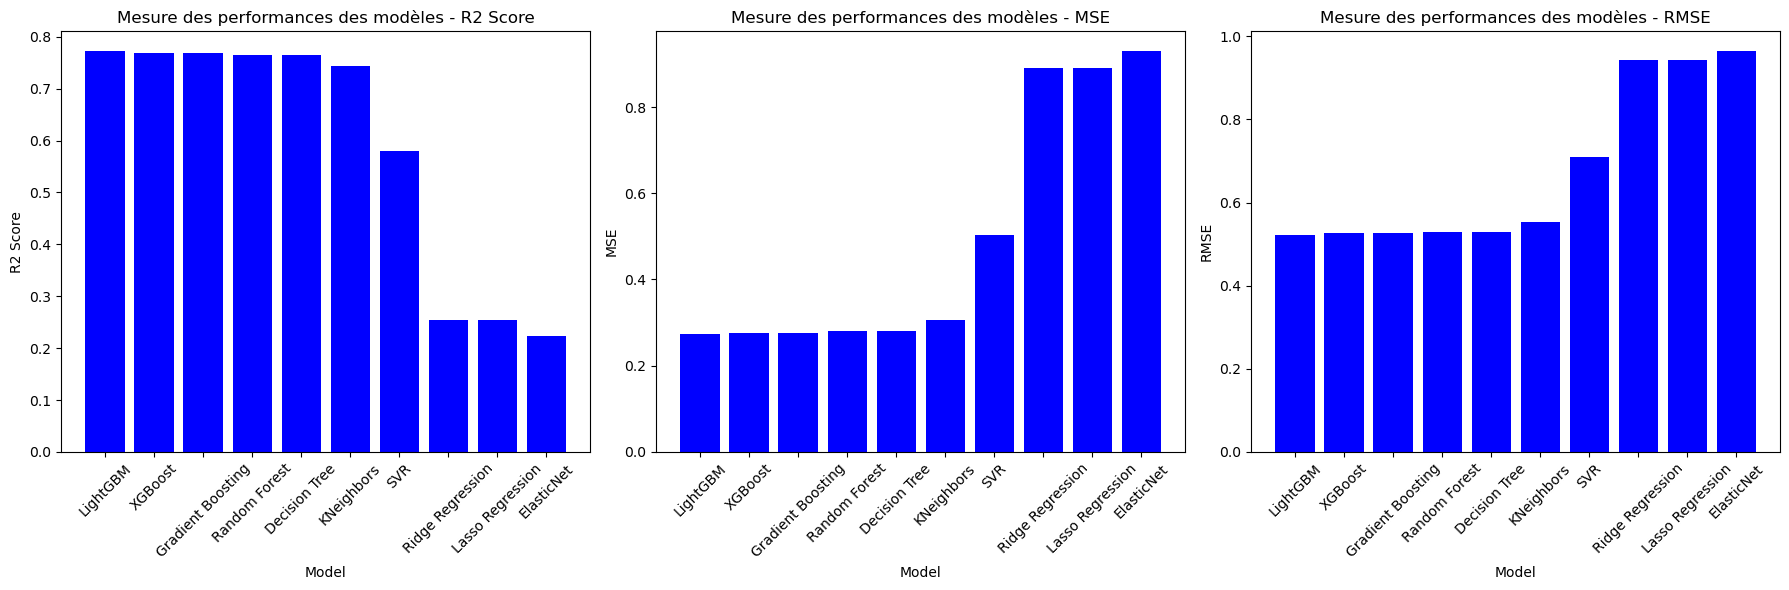

In [99]:
import matplotlib.pyplot as plt
import pandas as pd

results_df=pd.read_csv("results_ML_random_sorted_by_R4.csv")
# Définir les métriques à tracer
metrics = ['R2 Score', 'MSE', 'RMSE']

# Créer une figure avec des sous-graphiques pour chaque métrique
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  
axes = axes.flatten()

# Tracer chaque métrique
for i, metric in enumerate(metrics):
    axes[i].bar(results_df['Model'], results_df[metric], color='blue')
    axes[i].set_title(f'Mesure des performances des modèles - {metric}')
    axes[i].set_xlabel('Model')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()


# Recherche du meilleur modèle avec toutes les features

In [3]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from lightgbm import LGBMRegressor
from sklearn.cluster import KMeans

# Charger les données
X = pd.read_csv("C:/santé et comportement/tables/join_transformed_last1.csv")
print(X.columns)

# Sélectionner uniquement les colonnes numériques
X_numeric = X.select_dtypes(include=[np.number])

# Appliquer PCA pour réduire la dimension des données à 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_numeric)

# Appliquer K-means pour obtenir les labels des clusters
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_pca)

# Obtenir les labels du clustering
labels = kmeans.labels_

# Sélectionner les points du cluster 0
cluster_0_points = X[labels == 0]

# Séparer X et y 

y = cluster_0_points["Ntop"]
X = cluster_0_points.drop(columns=["Ntop", "Npop", "prev","patho_niv1"])
X.columns = X.columns.str.strip()

# Séparer les caractéristiques et la cible en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Dimensions de X_train et y_train :")
print(X_train.shape, y_train.shape)

Index(['sexeps', 'fqcantine', 'entrerep', 'fastfood', 'enrich', 'cyclepds',
       'enceinte', 'allaite', 'menopaus', 'ths', 'fume', 'agefumem', 'dlcpl',
       'contmed', 'contsubt', 'fqvpo', 'fqpl', 'pasreg', 'acolmat1_gr',
       'acolmat2_gr', 'acolmat3_gr', 'acolmat4_gr', 'agglo9', 'situ_mat',
       'situ_prof', 'heur_trav', 'trav_nuit', 'typ_empl', 'stat_empl',
       'vacances', 'region', 'dip', 'bmi', 'statnut', 'ipaq', 'taille',
       'saison', 'typelait', 'annee', 'patho_niv1', 'cla_age_5', 'dept',
       'Ntop', 'Npop', 'prev', 'mois', 'pm10', 'pm2_5', 'carbon_monoxide',
       'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 'grass_pollen',
       'ajout_sel', 'temps_act_phy', 'p_animal', 'p_vegetale', 'gras_animal',
       'vistes_medecins', 'fumeur', 'sedentaire', 'regime_special',
       'achats_distributeurs', 'poids_moyen'],
      dtype='object')
Dimensions de X_train et y_train :
(163316, 60) (163316,)


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor 
import xgboost as xgb
import joblib
import gc  # Importing the garbage collector

# Initialiser le DataFrame pour les résultats
results_df = pd.DataFrame(columns=['Model', 'Best Params', 'R2 Score', 'MSE', 'RMSE'])

# Définir les modèles à tester et les paramètres pour RandomizedSearchCV
models = {
    'Lasso Regression': Lasso(),
    'Ridge Regression': Ridge(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'ElasticNet': ElasticNet(),
    'LightGBM': LGBMRegressor(),
    'XGBoost': xgb.XGBRegressor(),
    'KNeighbors': KNeighborsRegressor()
}

param_grids = {
    'Lasso Regression': {'alpha': np.logspace(-4, 1, 10)},  
    'Ridge Regression': {'alpha': np.logspace(-4, 1, 10)}, 
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},  
    'Gradient Boosting': {'n_estimators': [100], 'learning_rate': [0.05], 'max_depth': [3, 5]}, 
    'SVR': {'C': [1.0], 'epsilon': [0.1]},  # Valeurs typiques utilisées dans SVR
    'Decision Tree': {'max_depth': [5, 10]}, 
    'ElasticNet': {'alpha': [0.1], 'l1_ratio': [0.5]},  # Valeurs typiques pour ElasticNet
    'LightGBM': {'n_estimators': [100], 'learning_rate': [0.05]},  
    'XGBoost': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [5, 10, 15]},  
    'KNeighbors': {'n_neighbors': [5, 10, 15]}
}

# Définir le K-Fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Définir le scorer pour RandomizedSearchCV
scorer = make_scorer(r2_score)

# Variables pour stocker les résultats des prédictions pour chaque modèle
all_y_test_vals = []
all_y_pred_vals = []
all_model_names = []

# Initialisation des meilleures performances
best_r2 = -np.inf # valeur négative
best_model = None
best_model_name = ""
best_params = {}

# Boucle d'entraînement et d'évaluation des modèles
for model_name, model in models.items():
    try:
        # Effectuer la recherche aléatoire des hyperparamètres pour chaque modèle
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grids[model_name],
            n_iter=4,  # le nombre d'itérations ajusté au fil des exécutions
            cv=kf,
            n_jobs=-1,
            verbose=2,
            random_state=42,
            scoring='r2'  # Utilisation du R² comme critère de score
        )
        
        random_search.fit(X_train, y_train)
        best_model_candidate = random_search.best_estimator_
        best_params_candidate = random_search.best_params_

        # Prédictions avec le meilleur modèle trouvé
        y_pred = best_model_candidate.predict(X_test)

        # Sauvegarder les valeurs de y_test et y_pred pour le plot
        all_y_test_vals.append(y_test)  # y_test est la valeur réelle
        all_y_pred_vals.append(y_pred)  # y_pred est la prédiction du modèle
        all_model_names.append(model_name)

        # Évaluer le modèle et obtenir ses métriques
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        # Sauvegarder les résultats dans le DataFrame
        results_df.loc[len(results_df)] = [model_name, str(best_params_candidate), r2, mse, rmse]

        # Si ce modèle a un meilleur R², le sauvegarder comme meilleur modèle
        if r2 > best_r2:
            best_r2 = r2
            best_model = best_model_candidate
            best_model_name = model_name
            best_params = best_params_candidate

        # Forcer la collecte de la mémoire après chaque itération
        gc.collect()

    except Exception as e:
        print(f"Erreur lors de l'ajustement du modèle {model_name} : {e}")
        continue  # Passer au modèle suivant

# Sauvegarder le meilleur modèle basé sur le R²
if best_model:
    joblib_file = f"{best_model_name.replace(' ', '_')}_best_model.pkl"
    joblib.dump(best_model, joblib_file)
    print(f"Le meilleur modèle ({best_model_name}) avec R² de {best_r2} a été sauvegardé dans le fichier : {joblib_file}")
else:
    print("Aucun modèle n'a été trouvé pour être sauvegardé.")

# Afficher les résultats triés par R²
results_df_sorted = results_df.sort_values(by='R2 Score', ascending=False)
print(results_df_sorted)

# Sauvegarder les résultats triés dans un fichier CSV
results_df_sorted.to_csv("results_ML_without_features.csv", index=False)

# Forcer la collecte de la mémoire à la fin
gc.collect()


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\fatma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=4. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\fatma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=4. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\fatma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=4. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\fatma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=4. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\fatma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=4. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1405
[LightGBM] [Info] Number of data points in the train set: 163316, number of used features: 60
[LightGBM] [Info] Start training from score 0.018960
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\fatma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=4. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Le meilleur modèle (LightGBM) avec R² de 0.9650766627551974 a été sauvegardé dans le fichier : LightGBM_best_model.pkl
               Model                                        Best Params  \
7           LightGBM       {'n_estimators': 100, 'learning_rate': 0.05}   
2      Random Forest             {'n_estimators': 100, 'max_depth': 10}   
5      Decision Tree                                  {'max_depth': 10}   
8            XGBoost  {'n_estimators': 200, 'max_depth': 10, 'learni...   
3  Gradient Boosting  {'n_estimators': 100, 'max_depth': 5, 'learnin...   
9         KNeighbors                                 {'n_neighbors': 5}   
4                SVR                         {'epsilon': 0.1, 'C': 1.0}   
1   Ridge Regression                     {'alpha': 0.05994842503189409}   
0   Lasso Regression                                  {'alpha': 0.0001}   
6         ElasticNet                    {'l1_ratio': 0.5, 'alpha': 0.1} 

0

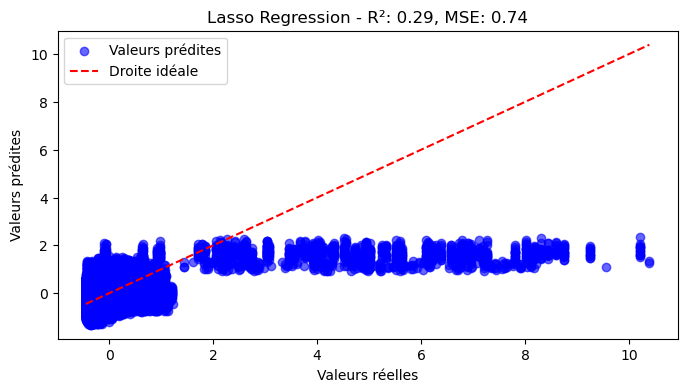

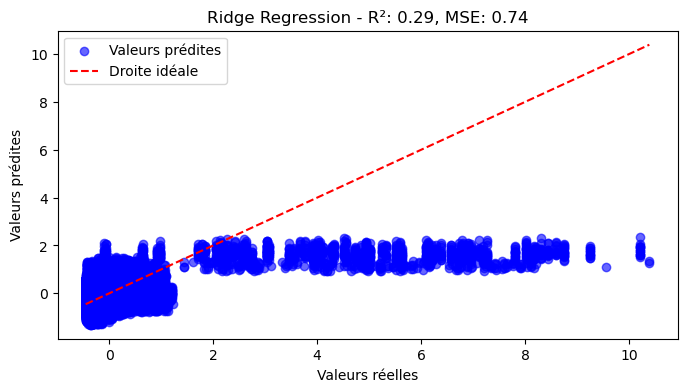

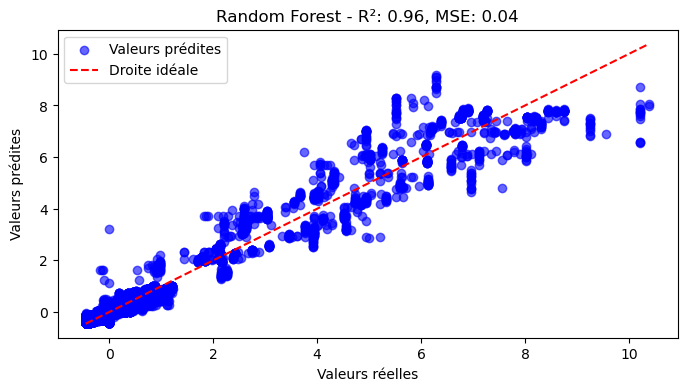

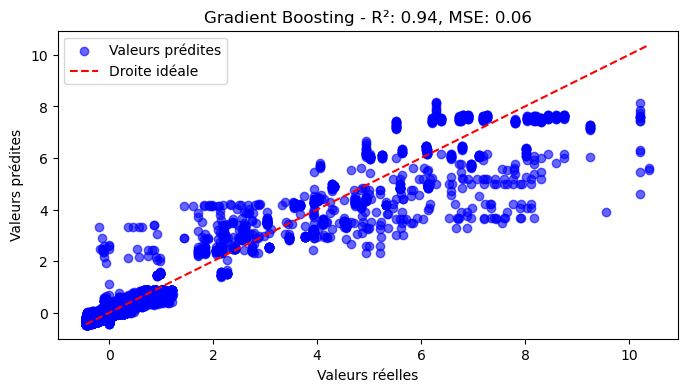

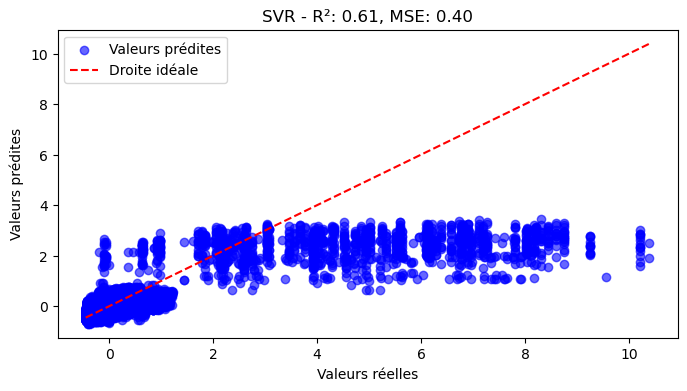

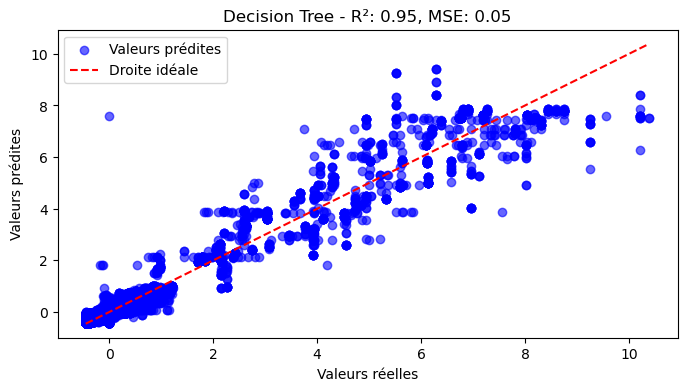

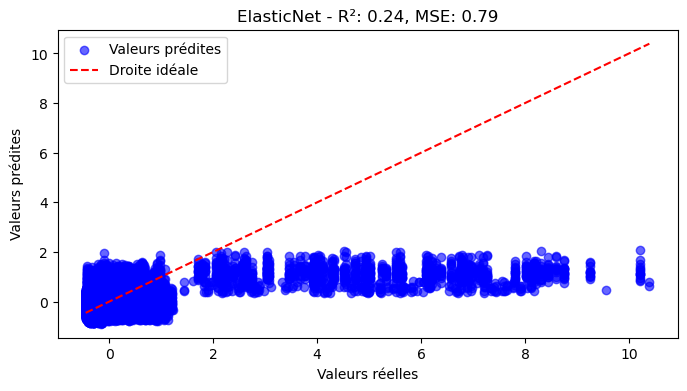

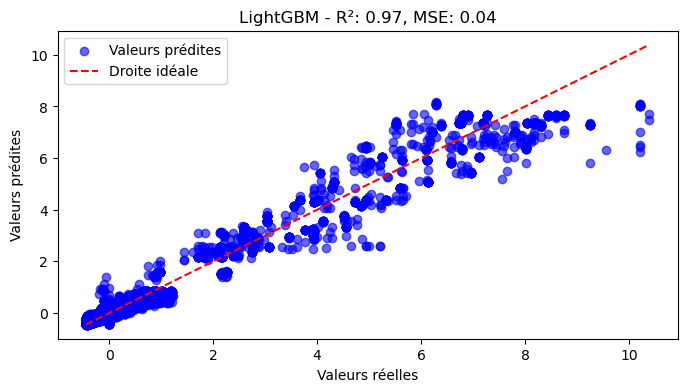

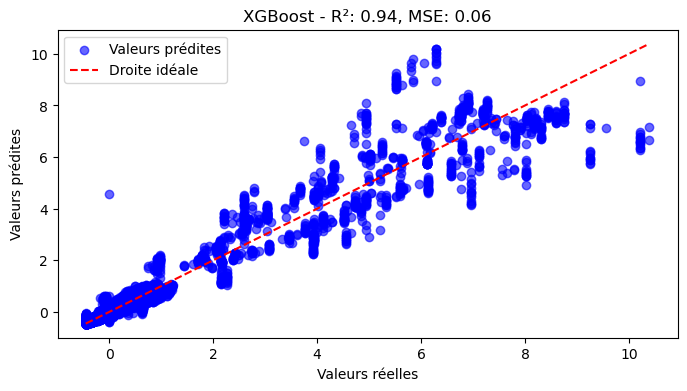

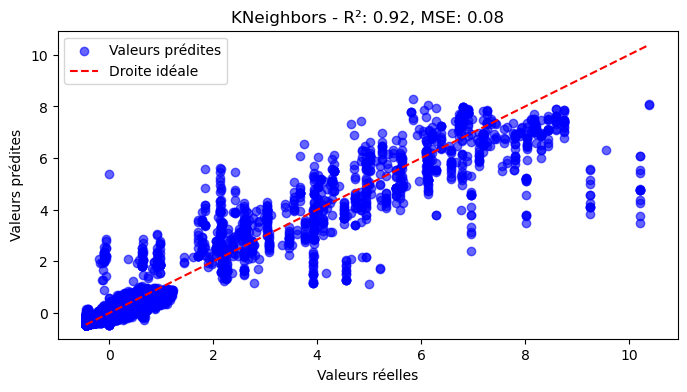

In [7]:
# Fonction pour afficher les résultats un par un
def plot_all_results_individually(all_y_test_vals, all_y_pred_vals, all_model_names):
    num_models = len(all_model_names)
    
    for i in range(num_models):
        try:
            # Récupérer les valeurs de y_test et y_pred pour le modèle courant
            y_test_vals = all_y_test_vals[i]
            y_pred_vals = all_y_pred_vals[i]
            model_name = all_model_names[i]
            
            # Calculer le R² et MSE pour afficher sur le graphique
            r2 = r2_score(y_test_vals, y_pred_vals)
            mse = mean_squared_error(y_test_vals, y_pred_vals)
            
            # Affichage des résultats avec nuage de points et droite idéale
            plt.figure(figsize=(8, 4))
            plt.scatter(y_test_vals, y_pred_vals, color='blue', label='Valeurs prédites', alpha=0.6)
            plt.plot([min(y_test_vals), max(y_test_vals)], [min(y_test_vals), max(y_test_vals)], color='red', linestyle='--', label='Droite idéale')
            
            # Ajouter des légendes et titres
            plt.legend()
            plt.title(f'{model_name} - R²: {r2:.2f}, MSE: {mse:.2f}')
            plt.xlabel('Valeurs réelles')
            plt.ylabel('Valeurs prédites')
            plt.show()
      
        except Exception as e:
            print(f"Erreur lors de l'évaluation du modèle {model_name}: {e}")
            continue  # Passer au modèle suivant

# Afficher les graphiques un par un
plot_all_results_individually(all_y_test_vals, all_y_pred_vals, all_model_names)

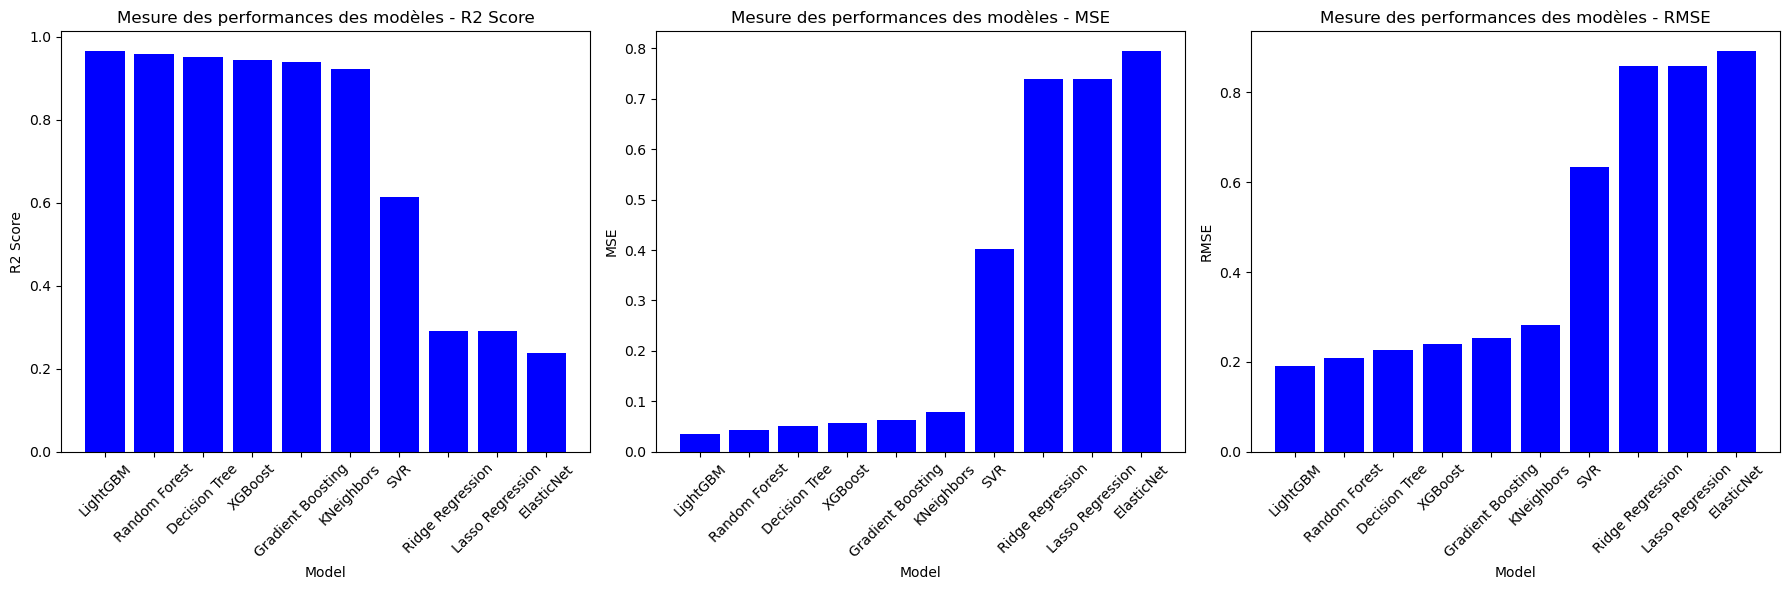

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

results_df=pd.read_csv("results_ML_without_features.csv")
# Définir les métriques à tracer
metrics = ['R2 Score', 'MSE', 'RMSE']

# Créer une figure avec des sous-graphiques pour chaque métrique
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  
axes = axes.flatten()

# Tracer chaque métrique
for i, metric in enumerate(metrics):
    axes[i].bar(results_df['Model'], results_df[metric], color='blue')
    axes[i].set_title(f'Mesure des performances des modèles - {metric}')
    axes[i].set_xlabel('Model')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

#  Détection d'overfitting-LightGBM à 30 meilleurs features et sur l'ensemble du DataFrame

In [12]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMRegressor
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import lightgbm as lgb  


In [14]:

df=pd.read_csv("join_transformed_last1.csv")

# Sélectionner les variables indépendantes (X) et la cible (y)
X = df.drop(columns=["Ntop", "patho_niv1", "Npop","cla_age_5", "prev"]) 

y = df["Ntop"]  # colonne cible

# Séparation en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser et entraîner le modèle de régression linéaire
model = LGBMRegressor()
model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)



# Évaluer la performance du modèle
mse=mean_squared_error(y_test, y_pred) 
rmse =np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)  # R²

# Affichage des résultats
print(f"RMSE : {rmse}")
print(f"R² : {r2}")

# Importance des caractéristiques
importances = model.feature_importances_

# Trier les caractéristiques par ordre décroissant
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]

# Les noms des caractéristiques
booster = model.booster_
feature_names = booster.feature_name()
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Créer un DataFrame avec les caractéristiques et leur importance
feature_importance_df = pd.DataFrame({'Feature': sorted_feature_names, 'Importance':sorted_importances})
print(feature_importance_df.head(10))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1876
[LightGBM] [Info] Number of data points in the train set: 838860, number of used features: 59
[LightGBM] [Info] Start training from score -0.000225
RMSE : 0.4810564805217435
R² : 0.7694146964145666
           Feature  Importance
0         cyclepds         652
1           region         518
2             dept         516
3            annee         337
4             mois         149
5             pm10          91
6  carbon_monoxide          47
7      poids_moyen          40
8   regime_special          38
9         p_animal          33


Dimensions de X_train et y_train :
(838860, 30) (838860,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1569
[LightGBM] [Info] Number of data points in the train set: 559240, number of used features: 30
[LightGBM] [Info] Start training from score -0.000786
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1569
[LightGBM] [Info] Number of data points in the train set: 559240, number of used features: 30
[LightGBM] [Info] Start training from score -0.000152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040859 seconds.
You can set `force_row

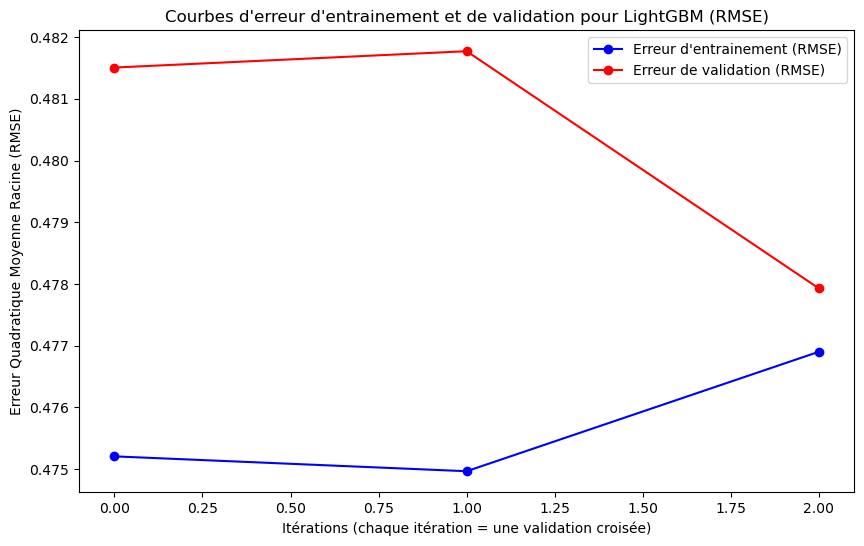

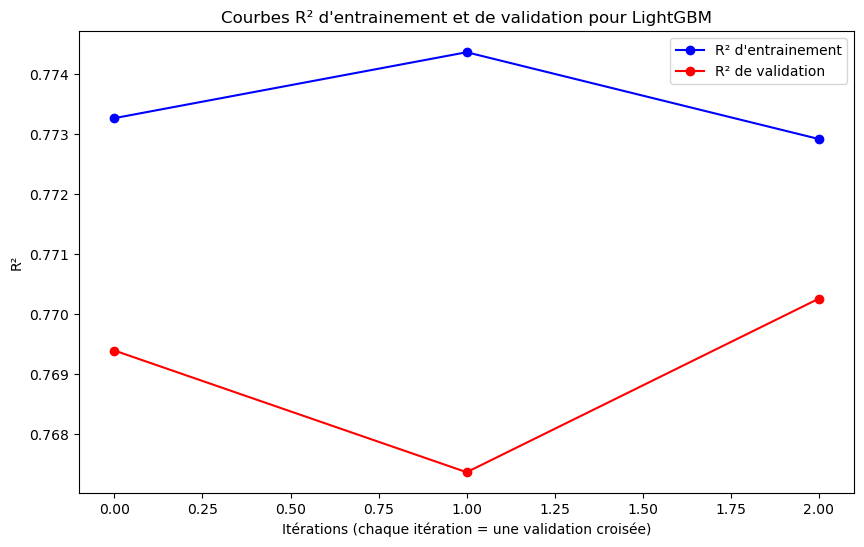

In [33]:
top_30_features = feature_importance_df.head(30)['Feature'].tolist()  # Extraire les noms des 30 meilleures caractéristiques

# Sélectionner les colonnes avec les meilleures caractéristiques dans le DataFrame d'origine
X = X[top_30_features]

# Séparer les caractéristiques et la cible en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Afficher les dimensions de X_train et y_train
print("Dimensions de X_train et y_train :")
print(X_train.shape, y_train.shape)


# Initialiser le modèle LightGBM avec les paramètres définis
model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)

# Initialiser les variables pour stocker les erreurs d'entraînement et de validation
train_errors, val_errors = [], []
train_r2_scores, val_r2_scores = [], []

# Définir le K-Fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Boucle d'entraînement avec K-Fold pour calculer les erreurs et R2
for train_index, val_index in kf.split(X_train):
    # Séparer l'entraînement et la validation selon les indices
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Entraîner le modèle sur le sous-ensemble d'entraînement
    model.fit(X_train_fold, y_train_fold)
    
    # Prédictions sur les données d'entraînement et de validation
    y_train_pred = model.predict(X_train_fold)
    y_val_pred = model.predict(X_val_fold)
    
    # Calculer les erreurs (RMSE = sqrt(MSE))
    train_rmse = np.sqrt(mean_squared_error(y_train_fold, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
    
    # Calculer les R2
    train_r2 = r2_score(y_train_fold, y_train_pred)
    val_r2 = r2_score(y_val_fold, y_val_pred)
    
    # Stocker les erreurs et les scores R2
    train_errors.append(train_rmse)
    val_errors.append(val_rmse)
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)

# Calculer la moyenne des erreurs et des scores R2
train_errors_mean = np.mean(train_errors)
val_errors_mean = np.mean(val_errors)
train_r2_mean = np.mean(train_r2_scores)
val_r2_mean = np.mean(val_r2_scores)

# Vérification du sur-apprentissage (overfitting)
if train_errors_mean < val_errors_mean and train_r2_mean > val_r2_mean:
    print("Il y a un risque de sur-apprentissage (overfitting).")
else:
    print("Le modèle semble bien se généraliser.")

# Afficher les résultats
print(f"Erreur d'entraînement moyenne (RMSE) : {train_errors_mean:.4f}")
print(f"Erreur de validation moyenne (RMSE) : {val_errors_mean:.4f}")
print(f"Score R² d'entraînement moyen : {train_r2_mean:.4f}")
print(f"Score R² de validation moyen : {val_r2_mean:.4f}")

# Tracer les courbes d'erreur d'entraînement et de validation (RMSE)
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Erreur d\'entrainement (RMSE)', color='blue', linestyle='-', marker='o')
plt.plot(val_errors, label='Erreur de validation (RMSE)', color='red', linestyle='-', marker='o')
plt.title('Courbes d\'erreur d\'entrainement et de validation pour LightGBM (RMSE)')
plt.xlabel('Itérations (chaque itération = une validation croisée)')
plt.ylabel('Erreur Quadratique Moyenne Racine (RMSE)')
plt.legend()
plt.show()

# Tracer les courbes R2 d'entraînement et de validation
plt.figure(figsize=(10, 6))
plt.plot(train_r2_scores, label='R² d\'entrainement', color='blue', linestyle='-', marker='o')
plt.plot(val_r2_scores, label='R² de validation', color='red', linestyle='-', marker='o')
plt.title('Courbes R² d\'entrainement et de validation pour LightGBM')
plt.xlabel('Itérations (chaque itération = une validation croisée)')
plt.ylabel('R²')
plt.legend()
plt.show()



# Ajustements LightGBM


[LightGBM] [Warning] lambda_l1 is set=0.7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1566
[LightGBM] [Info] Number of data points in the train set: 699050, number of used features: 30
[LightGBM] [Info] Start training from score 0.000245
[LightGBM] [Warning] lambda_l1 is set=0.7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. C

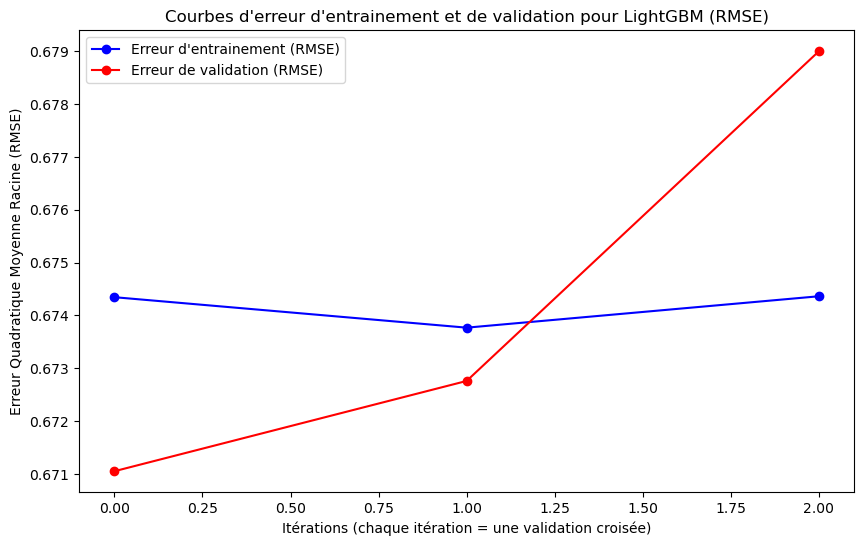

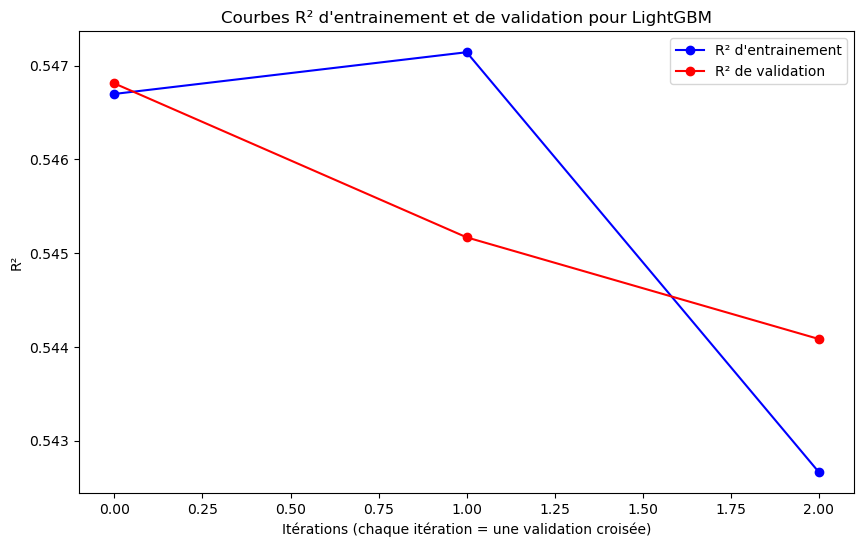

In [35]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score



# Initialiser les variables pour stocker les erreurs d'entraînement et de validation
train_errors, val_errors = [], []
train_r2_scores, val_r2_scores = [], []

# Définir le K-Fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Boucle d'entraînement avec K-Fold pour calculer les erreurs et R2
for train_index, val_index in kf.split(X):
    # Séparer l'entraînement et la validation selon les indices
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
    
    # Initialiser le modèle LightGBM avec des paramètres ajustés pour réduire l'overfitting
    model = lgb.LGBMRegressor(
        n_estimators=75,            # Réduction du nombre d'arbres 
        learning_rate=0.01,         # Réduction du taux d'apprentissage 
        random_state=42,
        max_depth=6,                # même profondeur que le modèle initial
        lambda_l1=0.7,              # Augmenter la régularisation L1 pour moins de complexité
        lambda_l2=0.7,              # Augmenter la régularisation L2 pour moins de complexité
        subsample=0.8,              # Sous-échantillonnage des données d'entraînement (aléaatoirement)
        min_child_samples=20        # Augmenter la taille minimale des échantillons pour chaque feuille
    )
    
    # Entraîner le modèle sur le sous-ensemble d'entraînement
    model.fit(
        X_train_fold, y_train_fold
    )
    
    # Prédictions sur les données d'entraînement et de validation
    y_train_pred = model.predict(X_train_fold)
    y_val_pred = model.predict(X_val_fold)
    
    # Calculer les erreurs (RMSE = sqrt(MSE))
    train_rmse = np.sqrt(mean_squared_error(y_train_fold, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
    
    # Calculer les R2
    train_r2 = r2_score(y_train_fold, y_train_pred)
    val_r2 = r2_score(y_val_fold, y_val_pred)
    
    # Stocker les erreurs et les scores R2
    train_errors.append(train_rmse)
    val_errors.append(val_rmse)
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)

# Calculer la moyenne des erreurs et des scores R2
train_errors_mean = np.mean(train_errors)
val_errors_mean = np.mean(val_errors)
train_r2_mean = np.mean(train_r2_scores)
val_r2_mean = np.mean(val_r2_scores)

# Vérification du sur-apprentissage (overfitting)
if train_errors_mean < val_errors_mean and train_r2_mean > val_r2_mean:
    print("Il y a un risque de sur-apprentissage (overfitting).")
else:
    print("Le modèle semble bien se généraliser.")

# Afficher les résultats
print(f"Erreur d'entraînement moyenne (RMSE) : {train_errors_mean:.4f}")
print(f"Erreur de validation moyenne (RMSE) : {val_errors_mean:.4f}")
print(f"Score R² d'entraînement moyen : {train_r2_mean:.4f}")
print(f"Score R² de validation moyen : {val_r2_mean:.4f}")

# Tracer les courbes d'erreur d'entraînement et de validation (RMSE)
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Erreur d\'entrainement (RMSE)', color='blue', linestyle='-', marker='o')
plt.plot(val_errors, label='Erreur de validation (RMSE)', color='red', linestyle='-', marker='o')
plt.title('Courbes d\'erreur d\'entrainement et de validation pour LightGBM (RMSE)')
plt.xlabel('Itérations (chaque itération = une validation croisée)')
plt.ylabel('Erreur Quadratique Moyenne Racine (RMSE)')
plt.legend()
plt.show()

# Tracer les courbes R2 d'entraînement et de validation
plt.figure(figsize=(10, 6))
plt.plot(train_r2_scores, label='R² d\'entrainement', color='blue', linestyle='-', marker='o')
plt.plot(val_r2_scores, label='R² de validation', color='red', linestyle='-', marker='o')
plt.title('Courbes R² d\'entrainement et de validation pour LightGBM')
plt.xlabel('Itérations (chaque itération = une validation croisée)')
plt.ylabel('R²')
plt.legend()
plt.show()




Malgré les ajustements sur le modèle (réduction du nombre d'arbres, de leur profondeurs, du taux d'apprentissage), l'overfitting reste présent avec une réduction des performances du modèle qui se manifestent en R² et en RMSE.

Dans la suite nous allons continuer avec le modèle Xgboost qui est en 2 ème position dans nos résultats obtenus avec la clusterisation.

# Détection d'overfitting avec le modèle XgBoost à 30 features

In [31]:

X = X[top_30_features]
y = df["Ntop"]  # colonne cible

# Séparation en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



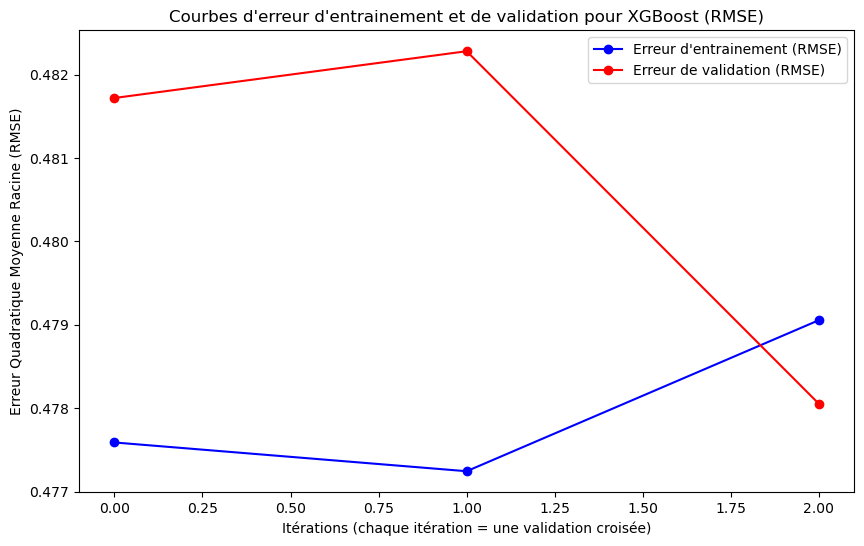

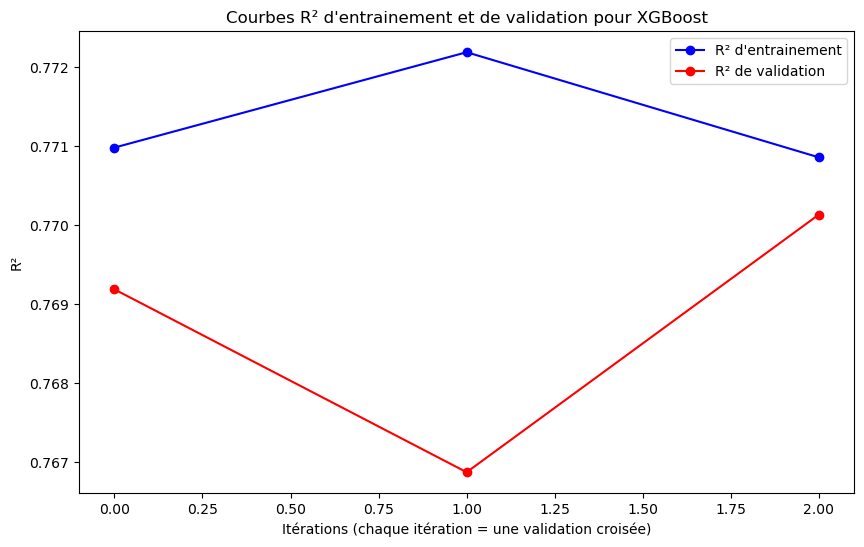

Erreur d'entraînement moyenne (RMSE) : 0.4780
Erreur de validation moyenne (RMSE) : 0.4807
Score R² d'entraînement moyen : 0.7713
Score R² de validation moyen : 0.7687


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Initialiser le modèle XGBoost avec les paramètres définis
model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42)

# Initialiser les variables pour stocker les erreurs d'entraînement et de validation
train_errors, val_errors = [], []
train_r2_scores, val_r2_scores = [], []

# Définir le K-Fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Boucle d'entraînement avec K-Fold pour calculer les erreurs et R2
for train_index, val_index in kf.split(X_train):
    # Séparer l'entraînement et la validation selon les indices
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Entraîner le modèle sur le sous-ensemble d'entraînement
    model.fit(X_train_fold, y_train_fold)
    
    # Prédictions sur les données d'entraînement et de validation
    y_train_pred = model.predict(X_train_fold)
    y_val_pred = model.predict(X_val_fold)
    
    # Calculer les erreurs (RMSE = sqrt(MSE))
    train_rmse = np.sqrt(mean_squared_error(y_train_fold, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
    
    # Calculer les R2
    train_r2 = r2_score(y_train_fold, y_train_pred)
    val_r2 = r2_score(y_val_fold, y_val_pred)
    
    # Stocker les erreurs et les scores R2
    train_errors.append(train_rmse)
    val_errors.append(val_rmse)
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)

# Calculer la moyenne des erreurs et des scores R2
train_errors_mean = np.mean(train_errors)
val_errors_mean = np.mean(val_errors)
train_r2_mean = np.mean(train_r2_scores)
val_r2_mean = np.mean(val_r2_scores)

# Tracer les courbes d'erreur d'entraînement et de validation (RMSE)
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Erreur d\'entrainement (RMSE)', color='blue', linestyle='-', marker='o')
plt.plot(val_errors, label='Erreur de validation (RMSE)', color='red', linestyle='-', marker='o')
plt.title('Courbes d\'erreur d\'entrainement et de validation pour XGBoost (RMSE)')
plt.xlabel('Itérations (chaque itération = une validation croisée)')
plt.ylabel('Erreur Quadratique Moyenne Racine (RMSE)')
plt.legend()
plt.show()

# Tracer les courbes R2 d'entraînement et de validation
plt.figure(figsize=(10, 6))
plt.plot(train_r2_scores, label='R² d\'entrainement', color='blue', linestyle='-', marker='o')
plt.plot(val_r2_scores, label='R² de validation', color='red', linestyle='-', marker='o')
plt.title('Courbes R² d\'entrainement et de validation pour XGBoost')
plt.xlabel('Itérations (chaque itération = une validation croisée)')
plt.ylabel('R²')
plt.legend()
plt.show()

# Afficher les erreurs moyennes et les scores R² moyens pour chaque ensemble
print(f"Erreur d'entraînement moyenne (RMSE) : {train_errors_mean:.4f}")
print(f"Erreur de validation moyenne (RMSE) : {val_errors_mean:.4f}")
print(f"Score R² d'entraînement moyen : {train_r2_mean:.4f}")
print(f"Score R² de validation moyen : {val_r2_mean:.4f}")




Bien que les résultats soient bons et indiquent une généralisation relativement forte, il y a des signes possibles de légèrement sur-apprentissage (overfitting), comme l'indique l'écart entre l'erreur d'entraînement et de validation. Le modèle semble très performant sur les données de validation, mais il peut encore être amélioré pour mieux généraliser sur les données d'entrainement. 

# Ajustements du modèles XgBoost  

Plusieurs ajustements ont été réalisés sur le modèle obtenu lors de l'étape de clustering, afin qu'il s'adapte mieux, se régularise de manière optimale et évite le sur-apprentissage. Ces ajustements portent sur le nombre d'estimateurs (arbres), la profondeur des arbres et le taux d'apprentissage.

In [ ]:

X = X[top_30_features]
y = df["Ntop"]  # colonne cible
# Séparation en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Séparer les caractéristiques et la cible en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[0]	train-rmse:0.99339	eval-rmse:0.99566
[1]	train-rmse:0.98732	eval-rmse:0.98960
[2]	train-rmse:0.98133	eval-rmse:0.98363
[3]	train-rmse:0.97542	eval-rmse:0.97774
[4]	train-rmse:0.96960	eval-rmse:0.97193
[5]	train-rmse:0.96386	eval-rmse:0.96620
[6]	train-rmse:0.95819	eval-rmse:0.96056
[7]	train-rmse:0.95261	eval-rmse:0.95499
[8]	train-rmse:0.94711	eval-rmse:0.94950
[9]	train-rmse:0.94024	eval-rmse:0.94260
[10]	train-rmse:0.93346	eval-rmse:0.93579
[11]	train-rmse:0.92817	eval-rmse:0.93052
[12]	train-rmse:0.92154	eval-rmse:0.92386
[13]	train-rmse:0.91499	eval-rmse:0.91729
[14]	train-rmse:0.90854	eval-rmse:0.91081
[15]	train-rmse:0.90352	eval-rmse:0.90581
[16]	train-rmse:0.89719	eval-rmse:0.89945
[17]	train-rmse:0.89094	eval-rmse:0.89317
[18]	train-rmse:0.88477	eval-rmse:0.88697
[19]	train-rmse:0.87868	eval-rmse:0.88086
[20]	train-rmse:0.87398	eval-rmse:0.87618
[21]	train-rmse:0.86803	eval-rmse:0.87021
[22]	train-rmse:0.86217	eval-rmse:0.86431
[23]	train-rmse:0.85640	eval-rmse:0.85852
[2

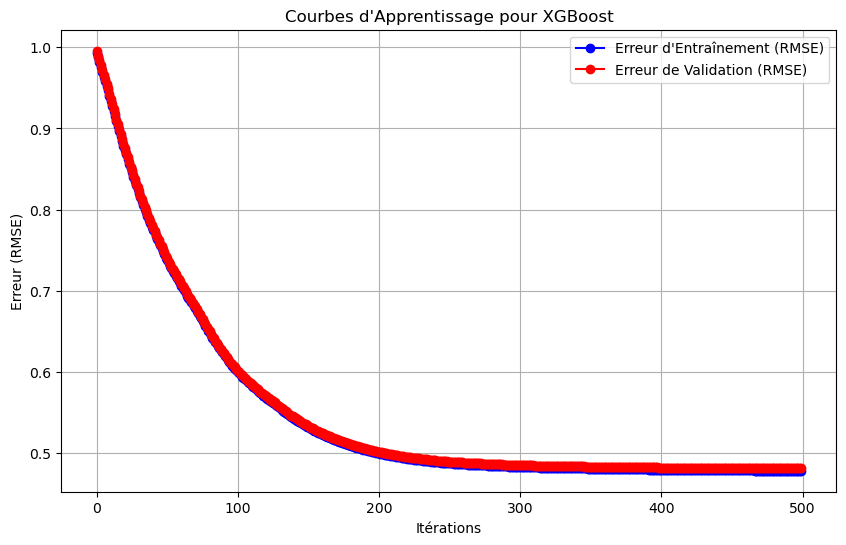

Score R² d'entraînement : 0.7707
Score R² de validation : 0.7691


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Initialiser le modèle XGBoost
model = xgb.XGBRegressor(
    n_estimators=500,  # Augmentation du nombre d'arbres 100 au départ
    max_depth=5,       #profondeur maintenue à 5 
    learning_rate=0.01,  # Réduction du taux d'apprentissage de 0.05 à 0.01
    random_state=42
)

# DMatrix : transformer les jeux de données en format DMatrix optimisé pour XGBoost 
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)

# Paramètres du modèle
params = {
    'objective': 'reg:squarederror',  # Régression avec erreur quadratique
    'eval_metric': 'rmse',  # Utilisation de RMSE comme métrique
    'eta': 0.01,  # Learning rate au lieu de 0.05
    'max_depth': 5,  # Profondeur des arbres
}

# Suivi de l'entraînement avec un dictionnaire pour stocker les résultats
evals_result = {}

# Entraîner le modèle avec early stopping
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,  # Nombre d'itérations (arbres à créer)
    evals=[(dtrain, 'train'), (dval, 'eval')],
    early_stopping_rounds=10,  # Arrêt précoce si aucune amélioration du surapprentissage
    evals_result=evals_result,  # Pour récupérer les résultats d'évaluation
    verbose_eval=True
)

# Extraire et afficher les courbes d'apprentissage
train_errors = evals_result['train']['rmse']  # Erreurs d'entraînement
val_errors = evals_result['eval']['rmse']    # Erreurs de validation

# Calcul des R²
train_r2 = r2_score(y_train, model.predict(dtrain))
val_r2 = r2_score(y_test, model.predict(dval))



# Affichage des courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Erreur d\'Entraînement (RMSE)', color='blue', linestyle='-', marker='o')
plt.plot(val_errors, label='Erreur de Validation (RMSE)', color='red', linestyle='-', marker='o')
plt.title("Courbes d'Apprentissage pour XGBoost")
plt.xlabel('Itérations')
plt.ylabel('Erreur (RMSE)')
plt.legend()
plt.grid(True)
plt.show()

# Affichage des valeurs de R²
print(f"Score R² d'entraînement : {train_r2:.4f}")
print(f"Score R² de validation : {val_r2:.4f}")






Les courbes d'apprentissage se superposent et montrent une diminution continue de la RMSE, ce qui indique que le modèle s'améliore à la fois sur les données d'entraînement et de validation. Cela suggère que les ajustements apportés ont permis de réduire l'overfitting, entraînant ainsi une meilleure capacité de généralisation du modèle. Le fait que les courbes convergent et que la RMSE diminue pour les deux ensembles (entraînement et validation) témoigne d'une amélioration de la performance globale du modèle et d'une régularisation plus efficace. 

In [45]:
import joblib
# Sauvegarder le modèle avec joblib
joblib.dump(model, 'xgboost_model.joblib')
print("Modèle sauvegardé sous 'xgboost_model.joblib'")

Modèle sauvegardé sous 'xgboost_model.joblib'
